# Using several approaches to demonstrate multi-label classifications prediction on Women Health Care dataset

#### from https://medium.com/@cactuscode/multioutput-multiclass-classification-b0737a0693ec

![multiclasslabel](https://miro.medium.com/v2/resize:fit:720/format:webp/1*muF0oNLmdhfQ_Y0ayBQesA.png)

In [29]:
# Install necessary libraries
#!pip3 install scikit-learn
#!pip3 install scikit-multilearn

In [30]:
import warnings
warnings.filterwarnings('ignore')

In [31]:
import sklearn
print(sklearn.__version__)

1.4.1.post1


In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Image
%matplotlib inline
import seaborn as sns
sns.set_theme()

import time
from datetime import date, datetime, timedelta

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2
#from sklearn.preprocessing import MultiLabelBinarizer          ## Convert multi-label target variable into binary format
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, multilabel_confusion_matrix, roc_curve, roc_auc_score, auc, f1_score, hamming_loss,  precision_recall_curve, average_precision_score

## Detail description of the dataset can be found in 
    https://www.drivendata.org/competitions/6/countable-care-modeling-womens-health-care-decisions/page/26/

#### This data is based on the National Survey of Family Growth conducted by the United States Center for Disease Control and Prevention. People across the United States were asked a series of over 1700 questions about their demographics, pregnancies, family planning, use of healthcare services, and medical insurance. We're focusing on the respondents to these questions that are women, and each row in the provided data represents an individual.

#### Train dataset (exclude id column) has 14644 rows and 1378 columns, 14 labels

#### Numeric variables start with n_, categorical variables start with c_, and ordinal variables start with o_.
    New data is released every few years in what the CDC calls a "cycle," and we have compiled a number of different release cycles together in this dataset. The "release" feature includes randomly ordered levels indicating to which cycle of the CDC data each row belongs. This could be useful to uncover patterns that have a temporal trend. Columns beginning with service_ are the labels 
#### https://www.kaggle.com/code/srikanth09556/multi-label-classification-women-health-care

In [33]:
# Women Health Care dataset from
# https://www.kaggle.com/datasets/ravikrishnareddy/women-health-care-requirements?resource=download

In [34]:
train_data = pd.read_csv("train Data.csv", delimiter=',')
train_labels = pd.read_csv("train labels.csv", delimiter=',')
test_data = pd.read_csv("test Data.csv", delimiter=',')

print("train data shape:", train_data.shape)
print("train labels shape:", train_labels.shape)
print("test data shape:", test_data.shape)

train data shape: (14644, 1379)
train labels shape: (14644, 15)
test data shape: (3661, 1379)


In [35]:
n_num = len(train_data[ [col for col in train_data if col.startswith('n_')]].axes[1])
n_ord = len(train_data[ [col for col in train_data if col.startswith('o_')]].axes[1])
n_cat = len(train_data[ [col for col in train_data if col.startswith('c_')]].axes[1])
print(f"number of numeric variables: {n_num}")
print(f"number of ordinal variables: {n_ord}")
print(f"number of categorical variables: {n_cat}")

number of numeric variables: 116
number of ordinal variables: 211
number of categorical variables: 1050


In [36]:
full_data = pd.concat([train_data,test_data], axis=0)
print("full data shape:", full_data.shape)

full data shape: (18305, 1379)


In [37]:
print(f"train set percentage {len(train_data)/len(full_data):.0%}")
print(f"test set percentage {len(test_data)/len(full_data):.0%}")

train set percentage 80%
test set percentage 20%


In [38]:
full_data.head()

id release  n_0000  n_0001    n_0002  n_0003  n_0004    n_0005  n_0006  \
0  11193       a     NaN     NaN  0.025449     NaN     NaN  0.368421     NaN   
1  11382       a     NaN     NaN  0.031297     NaN     NaN  0.315789     NaN   
2  16531       a     NaN     NaN  0.024475     NaN     NaN  0.342105     NaN   
3   1896       a     NaN     NaN  0.041694     NaN     NaN  0.447368     NaN   
4  18262       c     NaN     NaN  0.038120     NaN     NaN  0.315789     NaN   

   n_0007  ...  c_1368  c_1369  c_1370  c_1371  c_1372  c_1373  c_1374  \
0     NaN  ...     NaN     NaN     NaN     NaN       a     NaN       q   
1     NaN  ...     NaN     NaN       a     NaN       a     NaN     NaN   
2     NaN  ...     NaN     NaN       a     NaN       a     NaN       b   
3     NaN  ...     NaN     NaN     NaN     NaN       a     NaN     NaN   
4     NaN  ...     NaN     NaN       b     NaN       a     NaN       a   

   c_1375  c_1376  c_1377  
0     NaN     NaN     NaN  
1     NaN     NaN     NaN  
2     NaN     NaN     NaN  
3     NaN     NaN     NaN  
4     NaN     NaN     NaN  

[5 rows x 1379 columns]

In [39]:
train_labels.head()

id  service_a  service_b  service_c  service_d  service_e  service_f  \
0  11193          1          1          0          0          0          0   
1  11382          0          0          0          0          0          0   
2  16531          0          0          0          0          0          0   
3   1896          0          0          0          1          0          0   
4  18262          0          0          0          1          1          0   

   service_g  service_h  service_i  service_j  service_k  service_l  \
0          0          0          0          1          1          0   
1          0          0          0          1          1          0   
2          0          0          0          1          1          0   
3          0          0          0          1          0          1   
4          0          0          0          0          1          1   

   service_m  service_n  
0          0          0  
1          0          0  
2          0          0  
3          0          0  
4          1          0

In [40]:
# Analysis Ordinal data -- they are all numeric
df_ord = train_data[ [col for col in train_data if col.startswith('o_')]].melt(var_name='n_ord', value_name='n_values')
pd.crosstab(df_ord['n_ord'], df_ord['n_values'])

n_values  0.0    1.0    2.0    3.0    4.0    5.0    6.0    7.0    8.0    \
n_ord                                                                     
o_0116       38     32     22     29     17     26     28     25     23   
o_0117        1      0      0      0      0      0      0      0      0   
o_0118        7      3      5      2      2      5      3      6      1   
o_0119        1      2      1      1      1      4      2      2      3   
o_0120    10157   2969    909    279    188     54     49      0      0   
...         ...    ...    ...    ...    ...    ...    ...    ...    ...   
o_0322        2      1      1      1      2      1      3      3      5   
o_0323     3155      8      6      6      0      0      0      0      0   
o_0324      150    440    385      0      0      0      0      0      0   
o_0325        7     15      0      0      0      0      0      0      0   
o_0326      133    114    123     88    116    158    104    128    103   

n_values  9.0    ...  360.0  361.0  362.0  363.0  364.0  365.0  366.0  367.0  \
n_ord            ...                                                           
o_0116       25  ...      0      0      0      0      0      0      0      0   
o_0117        0  ...      0      0      0      0      0      0      0      0   
o_0118        3  ...      0      0      0      0      0      0      0      0   
o_0119        3  ...      0      0      0      0      0      0      0      0   
o_0120        0  ...      0      0      0      0      0      0      0      0   
...         ...  ...    ...    ...    ...    ...    ...    ...    ...    ...   
o_0322        8  ...      0      0      0      0      0      0      0      0   
o_0323        0  ...      0      0      0      0      0      0      0      0   
o_0324        0  ...      0      0      0      0      0      0      0      0   
o_0325        0  ...      0      0      0      0      0      0      0      0   
o_0326      109  ...      0      0      0      0      0      0      0      0   

n_values  368.0  369.0  
n_ord                   
o_0116        0      0  
o_0117        0      0  
o_0118        0      0  
o_0119        0      0  
o_0120        0      0  
...         ...    ...  
o_0322        0      0  
o_0323        0      0  
o_0324        0      0  
o_0325        0      0  
o_0326        0      0  

[211 rows x 369 columns]

In [41]:
df_ord['n_values'].unique()

array([ nan,   0.,   4.,   6.,   5.,   1.,   8.,   7.,  11.,   3.,   9.,
        10.,   2.,  21.,  27.,  15.,  19.,  17.,  32.,  24.,  28.,  25.,
        22.,  16.,  12.,  14.,  18.,  26.,  29.,  13.,  31.,  20.,  30.,
        23.,  33.,  34.,  37.,  35.,  36.,  43.,  40.,  38.,  39.,  41.,
        42.,  44.,  45., 303., 293., 131., 113., 240., 369., 338.,  95.,
       292., 149., 322.,  66., 300.,  97., 333., 315., 232., 104., 178.,
        69., 220., 122.,  73., 258., 139., 316., 173., 363., 276., 189.,
        89.,  71., 243.,  65., 190.,  67.,  75., 219., 154.,  58., 332.,
       187., 133.,  48., 222.,  59., 224.,  92.,  62., 368., 101., 358.,
       141., 310., 275., 343., 181., 237., 195., 285., 364., 245., 120.,
       318., 264., 123., 180., 203., 329., 161., 337., 163., 114., 231.,
       164., 352.,  86., 174., 230.,  94., 153., 254., 266., 157., 263.,
       208.,  83., 355.,  57., 249., 340.,  85., 226.,  64., 126., 312.,
       212., 228., 202., 366.,  96., 279.,  61., 21

In [42]:
# Analysis categorical data

df_cat = train_data[ [col for col in train_data if col.startswith('c_')]].melt(var_name='n_cat', value_name='n_values')
pd.crosstab(df_cat['n_cat'], df_cat['n_values'])

n_values  A  B  C  D  F  G    a     b    c    d  ...     q  r    s   t   u  \
n_cat                                            ...                         
c_0327    0  0  0  0  0  0   28     3   26    0  ...     0  0    0   0   0   
c_0328    0  0  0  0  0  0   12    11   36  438  ...     0  0    0   0   0   
c_0329    0  0  0  0  0  0    1     1    1    1  ...     0  0    0   0   0   
c_0330    0  0  0  0  0  0  115    13  123   20  ...     0  0    0   0   0   
c_0331    0  0  0  0  0  0    3     3    9    0  ...     0  0    0   0   0   
...      .. .. .. .. .. ..  ...   ...  ...  ...  ...   ... ..  ...  ..  ..   
c_1373    0  0  0  0  0  0  240    36  293   80  ...     0  0    0   0   0   
c_1374    0  0  0  0  0  0  372  2884  184    1  ...  1735  6  117  42  18   
c_1375    0  0  0  0  0  0    1    68    6    3  ...     7  2    8  32   0   
c_1376    0  0  0  0  0  0    4     4    0    0  ...     0  0    0   0   0   
c_1377    0  0  0  0  0  0  893  2680    0    0  ...     0  0    0   0   0   

n_values   v  w    x  y  z  
n_cat                       
c_0327     0  0    0  0  0  
c_0328     0  0    0  0  0  
c_0329     0  0    0  0  0  
c_0330     0  0    0  0  0  
c_0331     0  0    0  0  0  
...       .. ..  ... .. ..  
c_1373     0  0    0  0  0  
c_1374    10  6  250  0  0  
c_1375     0  0    0  0  0  
c_1376     0  0    0  0  0  
c_1377     0  0    0  0  0  

[1037 rows x 32 columns]

In [43]:
df_cat['n_values'].unique()

array([nan, 'a', 'c', 'b', 'd', 'e', 'f', 'i', 'h', 'k', 'm', 'j', 'l',
       'g', 'r', 's', 'o', 'q', 'p', 't', 'n', 'w', 'u', 'v', 'x', 'y',
       'B', 'G', 'C', 'D', 'A', 'z', 'F'], dtype=object)

In [44]:
# Instead of lower case letters, variable c_1259 has ‘G’ and ‘F’
# converting all the character values to small case letters.

categorical_columns = [col for col in train_data if col.startswith('c_')]
train_data[categorical_columns] = train_data[categorical_columns].applymap(lambda x: x.lower() if isinstance(x, str) else x)

In [45]:
# Check again - all converted to lowcase
df_cat = train_data[ [col for col in train_data if col.startswith('c_')]].melt(var_name='n_cat', value_name='n_values')
df_cat['n_values'].unique()

array([nan, 'a', 'c', 'b', 'd', 'e', 'f', 'i', 'h', 'k', 'm', 'j', 'l',
       'g', 'r', 's', 'o', 'q', 'p', 't', 'n', 'w', 'u', 'v', 'x', 'y',
       'z'], dtype=object)

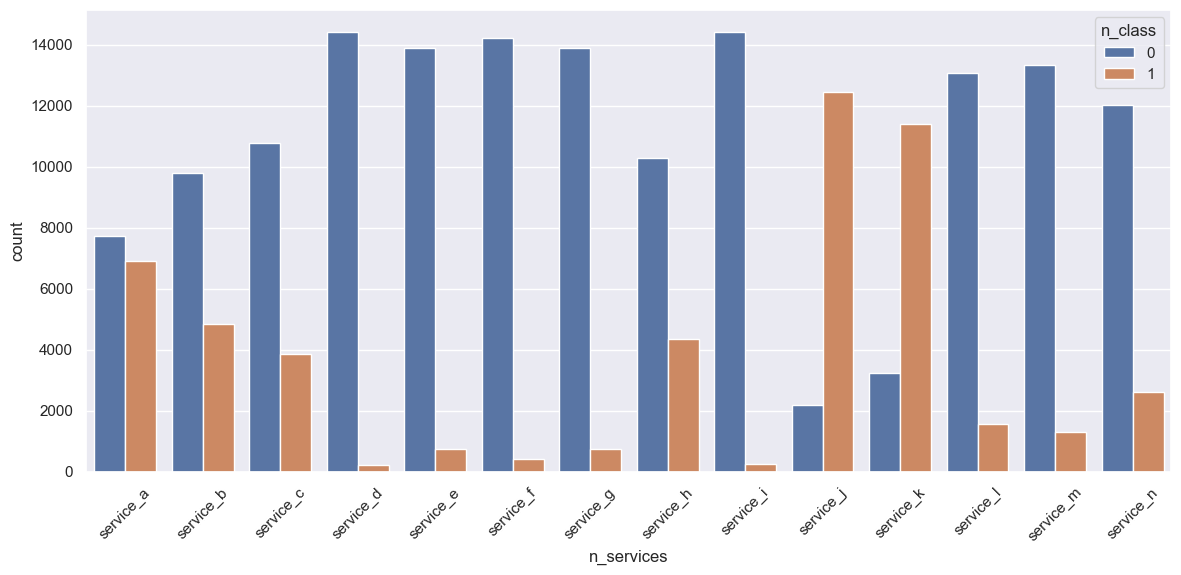

In [46]:
# get the total count of the labels columns
plt.figure(figsize=(14,6))
df_labels = train_labels.iloc[:,1:15].melt(var_name='n_services', value_name='n_class')
sns.countplot(data=df_labels, x='n_services', hue='n_class')
plt.xticks(rotation=45)
plt.show()

### Data Preprocessing

In [47]:
# imputation function for integers (continues)
def impute_int(df,column):
    df[column] = df[column].fillna(df[column].mean()) 

In [48]:
#full_data2 = full_data.copy()
train_data2 = train_data.copy()

impute_int(train_data2, [col for col in train_data2 if col.startswith('n_')])

In [49]:
#Looking for null values
train_data2.isnull().sum().sort_values(ascending = False).head(30)

c_1277    14644
c_1332    14644
c_0803    14644
c_0541    14644
c_0529    14644
c_0848    14644
c_0708    14644
c_0784    14644
c_1230    14644
c_0491    14644
n_0101    14644
c_1257    14644
c_0902    14644
c_1009    14644
c_0701    14643
o_0226    14643
o_0233    14643
c_0693    14643
o_0224    14643
c_0710    14643
o_0220    14643
o_0211    14643
c_0763    14643
o_0185    14643
o_0237    14643
o_0184    14643
o_0164    14643
c_1072    14643
o_0171    14643
o_0166    14643
dtype: int64

In [56]:
len(train_data2.columns[train_data2.isna().any()].tolist())

1243

In [57]:
drop_list = train_data2.columns[train_data2.isna().any()].tolist()

train_data3 = train_data2.drop(columns=drop_list)
train_data3 = train_data3.drop(['release'], axis =1)
train_data3.shape

(14644, 135)

In [58]:
train_data3.columns

Index(['id', 'n_0000', 'n_0001', 'n_0002', 'n_0003', 'n_0004', 'n_0005',
       'n_0006', 'n_0007', 'n_0008',
       ...
       'c_0838', 'c_0870', 'c_0980', 'c_1145', 'c_1158', 'c_1189', 'c_1223',
       'c_1227', 'c_1244', 'c_1259'],
      dtype='object', length=135)

In [59]:
# creating dummies reading lables data set
train_data4 = pd.get_dummies(train_data3, dtype=int)
train_data4.shape

(14644, 209)

In [60]:
train_data4.head()

id    n_0000    n_0001    n_0002    n_0003    n_0004    n_0005  \
0  11193  0.388664  0.661216  0.025449  0.102976  0.345118  0.368421   
1  11382  0.388664  0.661216  0.031297  0.102976  0.345118  0.315789   
2  16531  0.388664  0.661216  0.024475  0.102976  0.345118  0.342105   
3   1896  0.388664  0.661216  0.041694  0.102976  0.345118  0.447368   
4  18262  0.388664  0.661216  0.038120  0.102976  0.345118  0.315789   

     n_0006    n_0007    n_0008  ...  c_1259_q  c_1259_r  c_1259_s  c_1259_t  \
0  0.197298  0.011224  0.444444  ...         0         0         0         0   
1  0.197298  0.011224  0.444444  ...         0         0         0         0   
2  0.197298  0.011224  0.444444  ...         0         0         0         0   
3  0.197298  0.011224  0.444444  ...         0         0         0         0   
4  0.197298  0.011224  0.444444  ...         0         0         0         0   

   c_1259_u  c_1259_v  c_1259_w  c_1259_x  c_1259_y  c_1259_z  
0         0         0         0         0         0         0  
1         0         0         0         0         0         0  
2         0         0         1         0         0         0  
3         0         0         0         0         0         0  
4         0         0         0         0         0         0  

[5 rows x 209 columns]

In [61]:
#X = train_data4.drop(['id', axis =1 )
#y = train_labels.drop(['id'], axis =1 )

X =  np.array(train_data4.drop(['id'], axis =1 ))
y =  np.array(train_labels.drop(['id'], axis =1 ))

In [62]:
#from sklearn.preprocessing import StandardScaler
#sc = StandardScaler()

#X_train = sc.fit_transform(X_train)
#X_test = sc.transform(X_test)

In [63]:
#!pip3 install iterative-stratification

In [64]:
print ('Creating Balanced Multi-Label Datasets for Model Training and Evaluation')
print ('=====================================')
# STRATIFICATION METHOD
print ("STRATIFICATION CROSS VALIDATION")
print ('=====================================')

# https://github.com/trent-b/iterative-stratification
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
mskf = MultilabelStratifiedKFold(n_splits=10, shuffle=True, random_state=123)

# Splitting data into training an test set
for train_index, test_index in mskf.split(X, y):
   #print("TRAIN:", train_index, "TEST:", test_index)
   X_train, X_test = X[train_index], X[test_index]
   y_train, y_test = y[train_index], y[test_index]
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)
print ('=====================================')

Creating Balanced Multi-Label Datasets for Model Training and Evaluation
STRATIFICATION CROSS VALIDATION
Train set: (13176, 208) (13176, 14)
Test set: (1468, 208) (1468, 14)


In [65]:
type(X_train), type(y_train)

(numpy.ndarray, numpy.ndarray)

#### from https://wimukthimadhusanka85.medium.com/multi-label-classification-e259896182da
![chart](https://miro.medium.com/v2/resize:fit:720/format:webp/1*Wqb6yYdDMNI18wzAKQ5hvg.png )

### Binary Relevance - RandomForestClassifier()
![Binary Relevance](https://miro.medium.com/v2/resize:fit:720/format:webp/1*sgL8ONH-KTNXt9TA9L4XWg.png)

In [66]:
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.ensemble import RandomForestClassifier

start=time.time()

brf_classifier = BinaryRelevance(
    classifier = RandomForestClassifier(),
    require_dense = [False, True]
)
brf_classifier.fit(X_train, y_train)
brf_y_hat=brf_classifier.predict(X_test)

#print('training time taken: ',round(time.time()-start,0),'seconds')

print("Time used: ",timedelta(seconds=time.time()-start))

Time used:  0:04:37.862294


In [78]:
# define Evaluation Metrics for Multi-Label Classification

def exact_match_ratio(y_true, y_pred):
    """
    Calculate the Exact Match Ratio (EMR)
    
    Parameters:
    y_true (list of list): True labels
    y_pred (list of list): Predicted labels
    
    Returns:
    float: EMR score
    """
    # Check each instance for match
    matches = np.all(y_true == y_pred, axis=1)
    
    # Calculate and return EMR
    emr = np.mean(matches)
    return emr

def getEvaluationMetrics (y_test, y_hat, clf_name=None):
    if clf_name is not None:
        print(clf_name)
    else:
        print()
    print ('                  EVALUATION') 
    print ('------------------------------------------------')
    emr = exact_match_ratio(y_test, y_hat)
    f1 = f1_score(y_test, y_hat, average='micro')
    hamm  = hamming_loss(y_test,y_hat)
    print('F1-score (micro):',round(f1,3))
    print('Hamming Loss:',round(hamm,3))
    print('Exact Match Ratio:',round(emr,3))
    print ('------------------------------------------------')
    print ('Classification Report')
    print ('------------------------------------------------')
    print (classification_report(y_test, y_hat))
    print ('------------------------------------------------')
    print('Multilabel Confusion Matrix')
    print ('------------------------------------------------')
    print(multilabel_confusion_matrix(y_test, y_hat))

In [82]:
# plot ROC Curves and Precision-Recall Curves

def plot_multilabel_auc_pr(n_classes, y_test, y_score, title):


    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    precision = dict()
    recall = dict()
    average_precision = dict()

    # Compute ROC curve and ROC area for each class
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        
        precision[i], recall[i], _ = precision_recall_curve(y_test[:, i], y_score[:, i])
        average_precision[i] = average_precision_score(y_test[:, i], y_score[:, i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    precision["micro"], recall["micro"], _ = precision_recall_curve(y_test.ravel(), y_score.ravel())
    average_precision["micro"] = average_precision_score(y_test.ravel(), y_score.ravel())

    # Plot ROC and Precision-Recall curves side-by-side
    plt.figure(figsize=(20, 10))

    # Plot ROC curves
    plt.subplot(1, 2, 1)
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], lw=2, label=f'label {i} (area = {roc_auc[i]:0.2f})')

    plt.plot(fpr["micro"], tpr["micro"], lw=4, linestyle='--', color='deeppink', label=f'Micro-average ROC curve (area = {roc_auc["micro"]:0.2f})')
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='gray', label='Random guess')

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic for Multilabel Classification', fontsize=14)
    plt.legend(loc="lower right", fontsize=14)

    # Plot Precision-Recall curves
    plt.subplot(1, 2, 2)
    for i in range(n_classes):
        plt.plot(recall[i], precision[i], lw=2, label=f'label {i} (AP = {average_precision[i]:0.2f})')

    plt.plot(recall["micro"], precision["micro"], lw=4, linestyle='--', color='deeppink', label=f'Micro-average Precision-Recall curve (AP = {average_precision["micro"]:0.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall for Multilabel Classification', fontsize=14)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12)
    
    # Add a title for the entire figure
    plt.suptitle(title, fontsize=22)
    
    plt.show()

In [81]:
getEvaluationMetrics (y_test, brf_y_hat, clf_name="BinaryRelevance - RandomForestClassifier()")

BinaryRelevance - RandomForestClassifier()
                  EVALUATION
------------------------------------------------
F1-score (micro): 0.718
Hamming Loss: 0.127
Exact Match Ratio: 0.289
------------------------------------------------
Classification Report
------------------------------------------------
              precision    recall  f1-score   support

           0       0.86      0.69      0.77       691
           1       0.67      0.51      0.58       485
           2       0.46      0.09      0.15       387
           3       0.00      0.00      0.00        22
           4       0.00      0.00      0.00        74
           5       0.00      0.00      0.00        43
           6       0.00      0.00      0.00        76
           7       0.75      0.39      0.51       437
           8       0.00      0.00      0.00        24
           9       0.88      0.98      0.93      1244
          10       0.81      0.97      0.88      1141
          11       0.77      0.15      0.

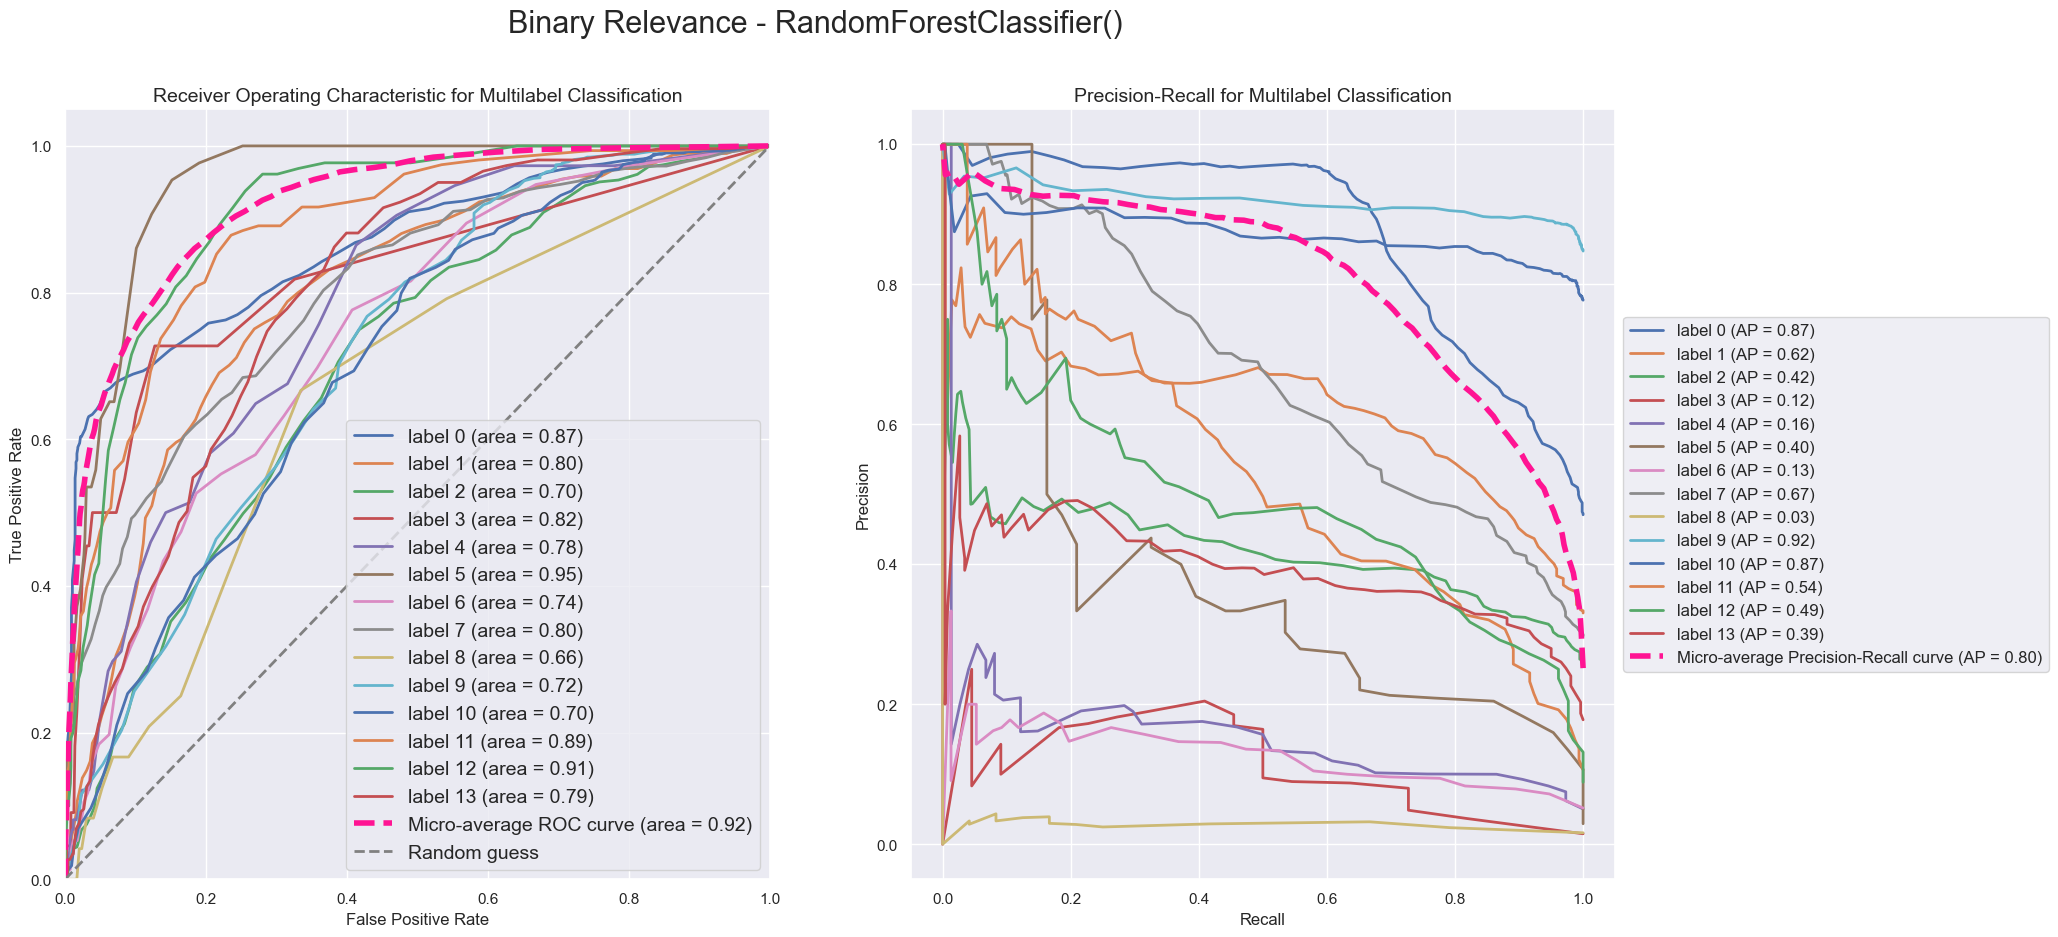

In [86]:
n_classes = y_train.shape[1]
brf_y_score = brf_classifier.predict_proba(X_test)   # it is scipy.sparse._lil.lil_matrix

# Convert y_score to dense numpy array if it's sparse
if hasattr(brf_y_score, 'toarray'):
    brf_y_score = brf_y_score.toarray()

plot_multilabel_auc_pr(n_classes, y_test, brf_y_score, 'Binary Relevance - RandomForestClassifier()' )

### Binary Relevance - LGBMClassifier()

In [87]:
# code modified from https://www.kaggle.com/code/hark99/predictive-analysis-medical-diseases
from lightgbm import LGBMClassifier
start=time.time()

blgb_classifier = BinaryRelevance(
    classifier = LGBMClassifier() 
)
blgb_classifier.fit(X_train, y_train)
blgb_y_hat=blgb_classifier.predict(X_test)

print("Time used: ",timedelta(seconds=time.time()-start))

[LightGBM] [Info] Number of positive: 6218, number of negative: 6958
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005871 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2530
[LightGBM] [Info] Number of data points in the train set: 13176, number of used features: 179
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.471919 -> initscore=-0.112444
[LightGBM] [Info] Start training from score -0.112444
[LightGBM] [Info] Number of positive: 4367, number of negative: 8809
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004867 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2530
[LightGBM] [Info] Number of data points in the train set: 13176, number of used features: 179
[LightGBM] [Info] [b

In [88]:
getEvaluationMetrics (y_test, blgb_y_hat, clf_name="BinaryRelevance - LGBMClassifier()")

BinaryRelevance - LGBMClassifier()
                  EVALUATION
------------------------------------------------
F1-score (micro): 0.732
Hamming Loss: 0.125
Exact Match Ratio: 0.282
------------------------------------------------
Classification Report
------------------------------------------------
              precision    recall  f1-score   support

           0       0.87      0.68      0.77       691
           1       0.65      0.62      0.64       485
           2       0.50      0.13      0.21       387
           3       0.50      0.05      0.08        22
           4       0.00      0.00      0.00        74
           5       0.57      0.28      0.38        43
           6       0.80      0.05      0.10        76
           7       0.74      0.48      0.58       437
           8       0.00      0.00      0.00        24
           9       0.88      0.98      0.93      1244
          10       0.82      0.96      0.88      1141
          11       0.61      0.29      0.40      

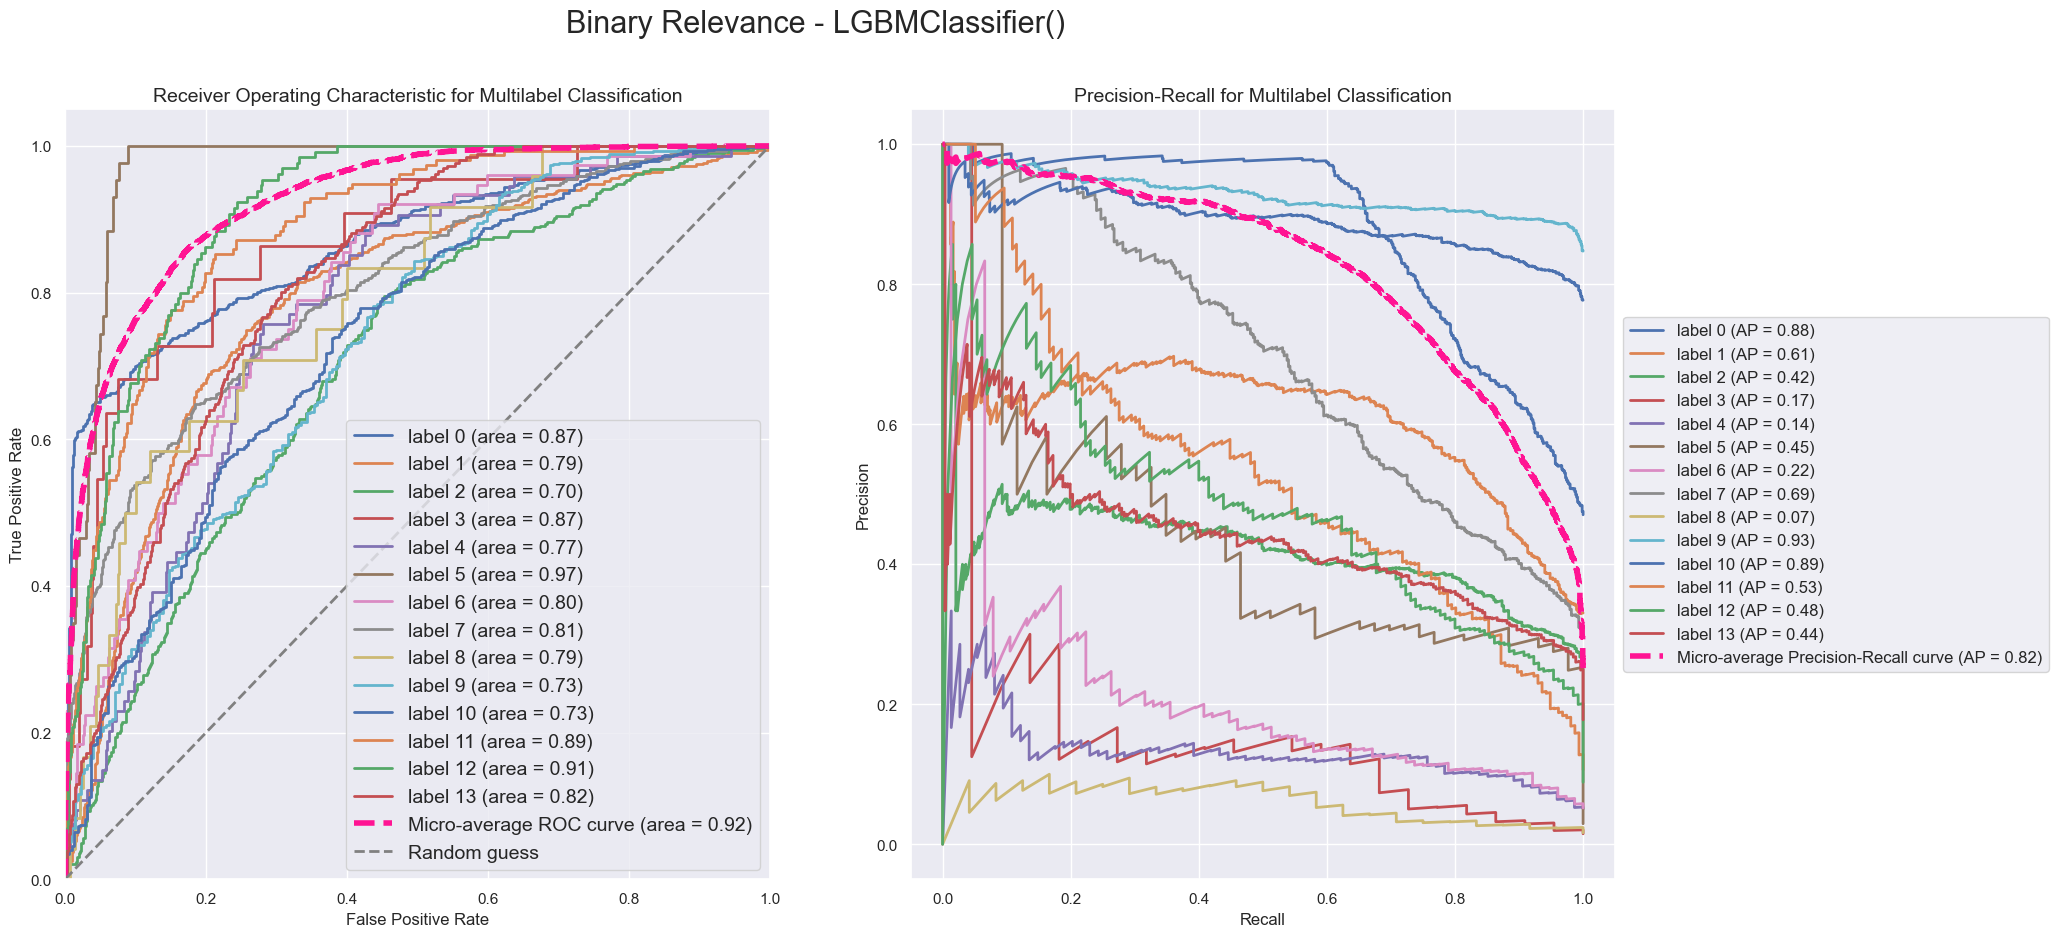

In [89]:
# Compute ROC curve and ROC area for each class
n_classes = y_train.shape[1]
blgb_y_score = blgb_classifier.predict_proba(X_test)   # it is scipy.sparse._lil.lil_matrix

# Convert y_score to dense numpy array if it's sparse
if hasattr(blgb_y_score, 'toarray'):
    blgb_y_score = blgb_y_score.toarray()

plot_multilabel_auc_pr(n_classes, y_test, blgb_y_score, 'Binary Relevance - LGBMClassifier()' )

### One-vs-the-rest (OvR) - XGBClassifier() 
####  OvR is also known as the binary relevance method.
#### This strategy can also be used for multilabel learning, where a classifier is used to predict multiple labels for instance, by fitting on a 2-d matrix in which cell [i, j] is 1 if sample i has label j and 0 otherwise.

In [90]:
# https://gabrielziegler3.medium.com/multiclass-multilabel-classification-with-xgboost-66195e4d9f2d

from sklearn.multiclass import OneVsRestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import MultiLabelBinarizer

start = time.time()
xgb_clf = OneVsRestClassifier(XGBClassifier(n_jobs=-1))

# You may need to use MultiLabelBinarizer to encode your variables from arrays [[x, y, z]] to a multilabel 
# format before training.
#mlb = MultiLabelBinarizer()
#y_train_mlb = mlb.fit_transform(y_train)
#y_test_mlb = mlb.fit_transform(y_test)
#xgb_clf.fit(X_train, y_train_mlb)

xgb_clf.fit(X_train, y_train)
xgb_y_hat = xgb_clf.predict(X_test)

print("Time used: ",timedelta(seconds=time.time()-start))

Time used:  0:00:10.161392


In [91]:
getEvaluationMetrics (y_test, xgb_y_hat, clf_name="OneVsRestClassifier - XGBClassifier()")

OneVsRestClassifier - XGBClassifier()
                  EVALUATION
------------------------------------------------
F1-score (micro): 0.724
Hamming Loss: 0.129
Exact Match Ratio: 0.26
------------------------------------------------
Classification Report
------------------------------------------------
              precision    recall  f1-score   support

           0       0.85      0.70      0.77       691
           1       0.64      0.55      0.59       485
           2       0.48      0.19      0.28       387
           3       0.00      0.00      0.00        22
           4       0.67      0.03      0.05        74
           5       0.65      0.30      0.41        43
           6       0.33      0.04      0.07        76
           7       0.69      0.48      0.57       437
           8       0.00      0.00      0.00        24
           9       0.89      0.98      0.93      1244
          10       0.82      0.94      0.87      1141
          11       0.62      0.32      0.42    

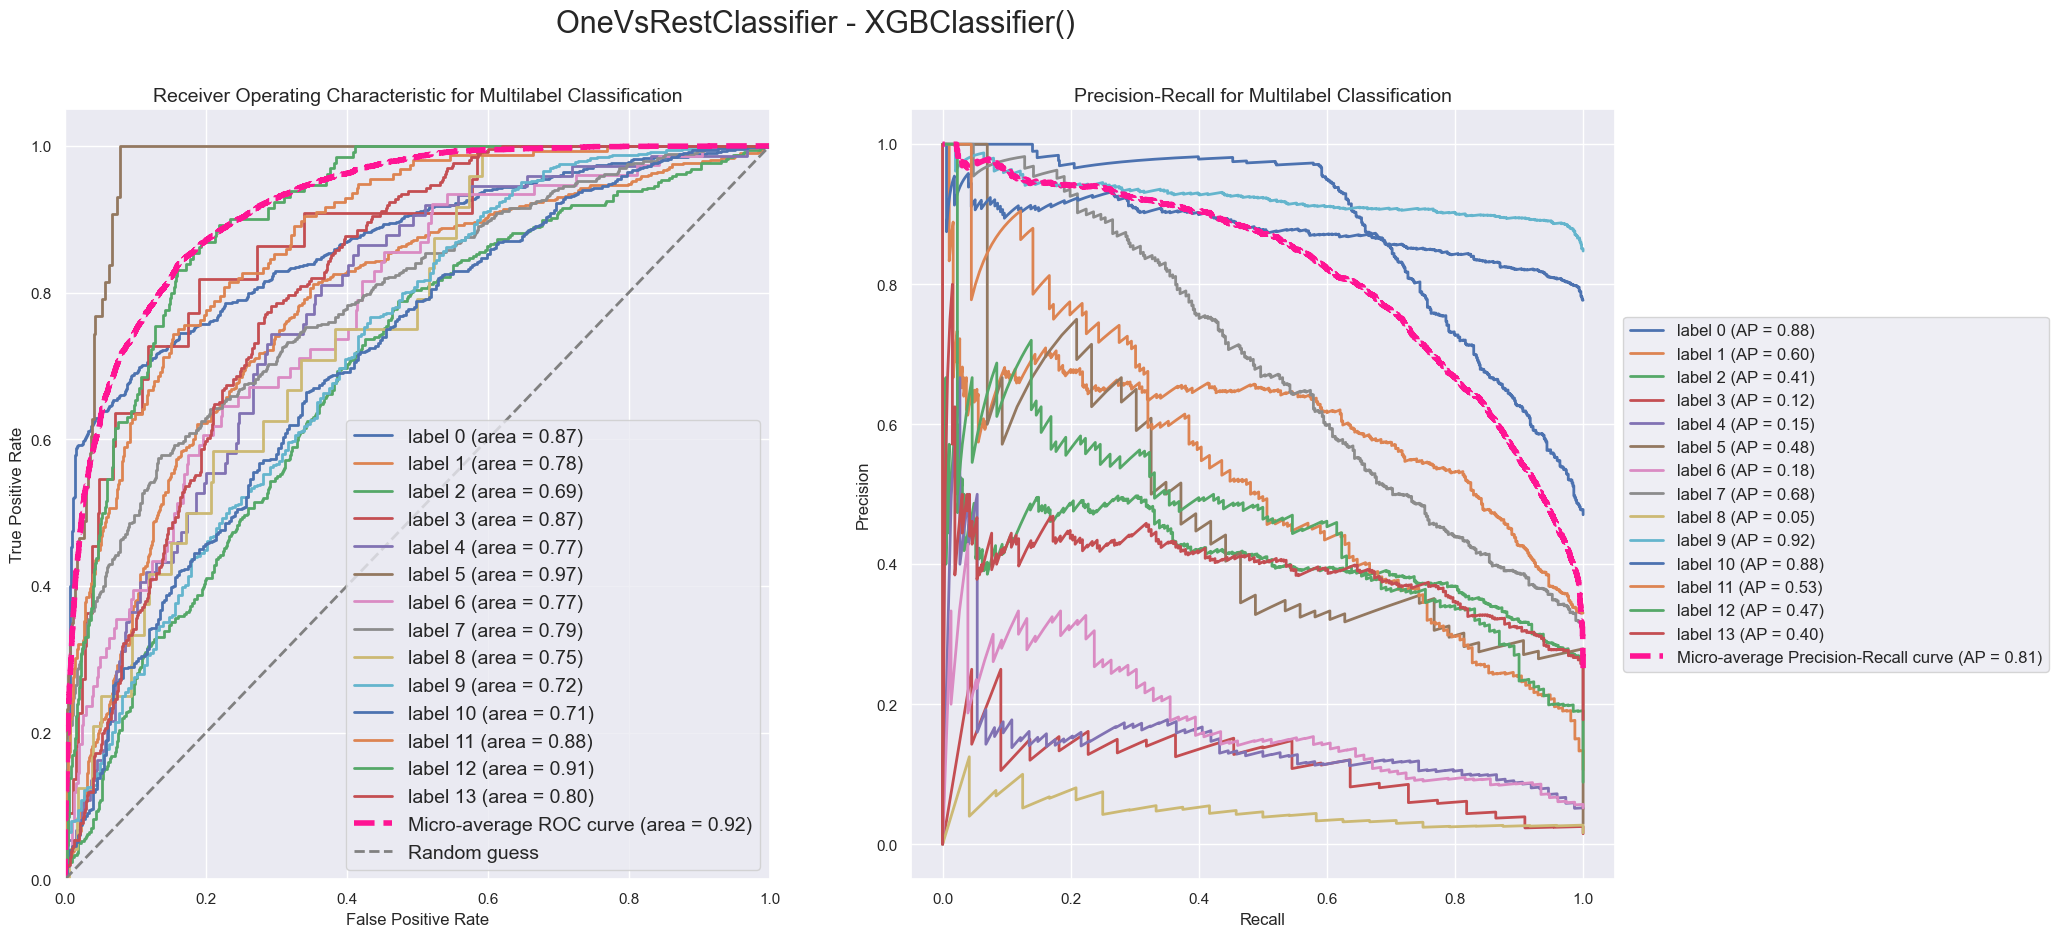

In [92]:
# Compute ROC curve and ROC area for each class
n_classes = y_train.shape[1]
xgb_y_score = xgb_clf.predict_proba(X_test)   # it is numpy.ndarray

plot_multilabel_auc_pr(n_classes, y_test, xgb_y_score, 'OneVsRestClassifier - XGBClassifier()' )

### MultiOutputClassifier - XGBClassifier() 
### This strategy consists of fitting one classifier per target. 

![chart2](https://scikit-learn.org/stable/_images/multi_org_chart.png)

In [93]:
# https://www.kaggle.com/code/dongr0510/multi-label-classification-simple-example
from sklearn.multioutput import MultiOutputClassifier
#from sklearn.pipeline import Pipeline
#classifier = MultiOutputClassifier(XGBClassifier())
#mxgb_clf = Pipeline([('classify', classifier)         ])

start = time.time()
mxgb_clf =  MultiOutputClassifier( XGBClassifier() )
mxgb_clf.fit(X_train, y_train)
mxgb_y_hat = mxgb_clf.predict(X_test)

print("Time used: ",timedelta(seconds=time.time()-start))

Time used:  0:00:10.059668


In [94]:
getEvaluationMetrics (y_test, mxgb_y_hat, clf_name="MultiOutputClassifier - XGBClassifier()")

MultiOutputClassifier - XGBClassifier()
                  EVALUATION
------------------------------------------------
F1-score (micro): 0.724
Hamming Loss: 0.129
Exact Match Ratio: 0.26
------------------------------------------------
Classification Report
------------------------------------------------
              precision    recall  f1-score   support

           0       0.85      0.70      0.77       691
           1       0.64      0.55      0.59       485
           2       0.48      0.19      0.28       387
           3       0.00      0.00      0.00        22
           4       0.67      0.03      0.05        74
           5       0.65      0.30      0.41        43
           6       0.33      0.04      0.07        76
           7       0.69      0.48      0.57       437
           8       0.00      0.00      0.00        24
           9       0.89      0.98      0.93      1244
          10       0.82      0.94      0.87      1141
          11       0.62      0.32      0.42  

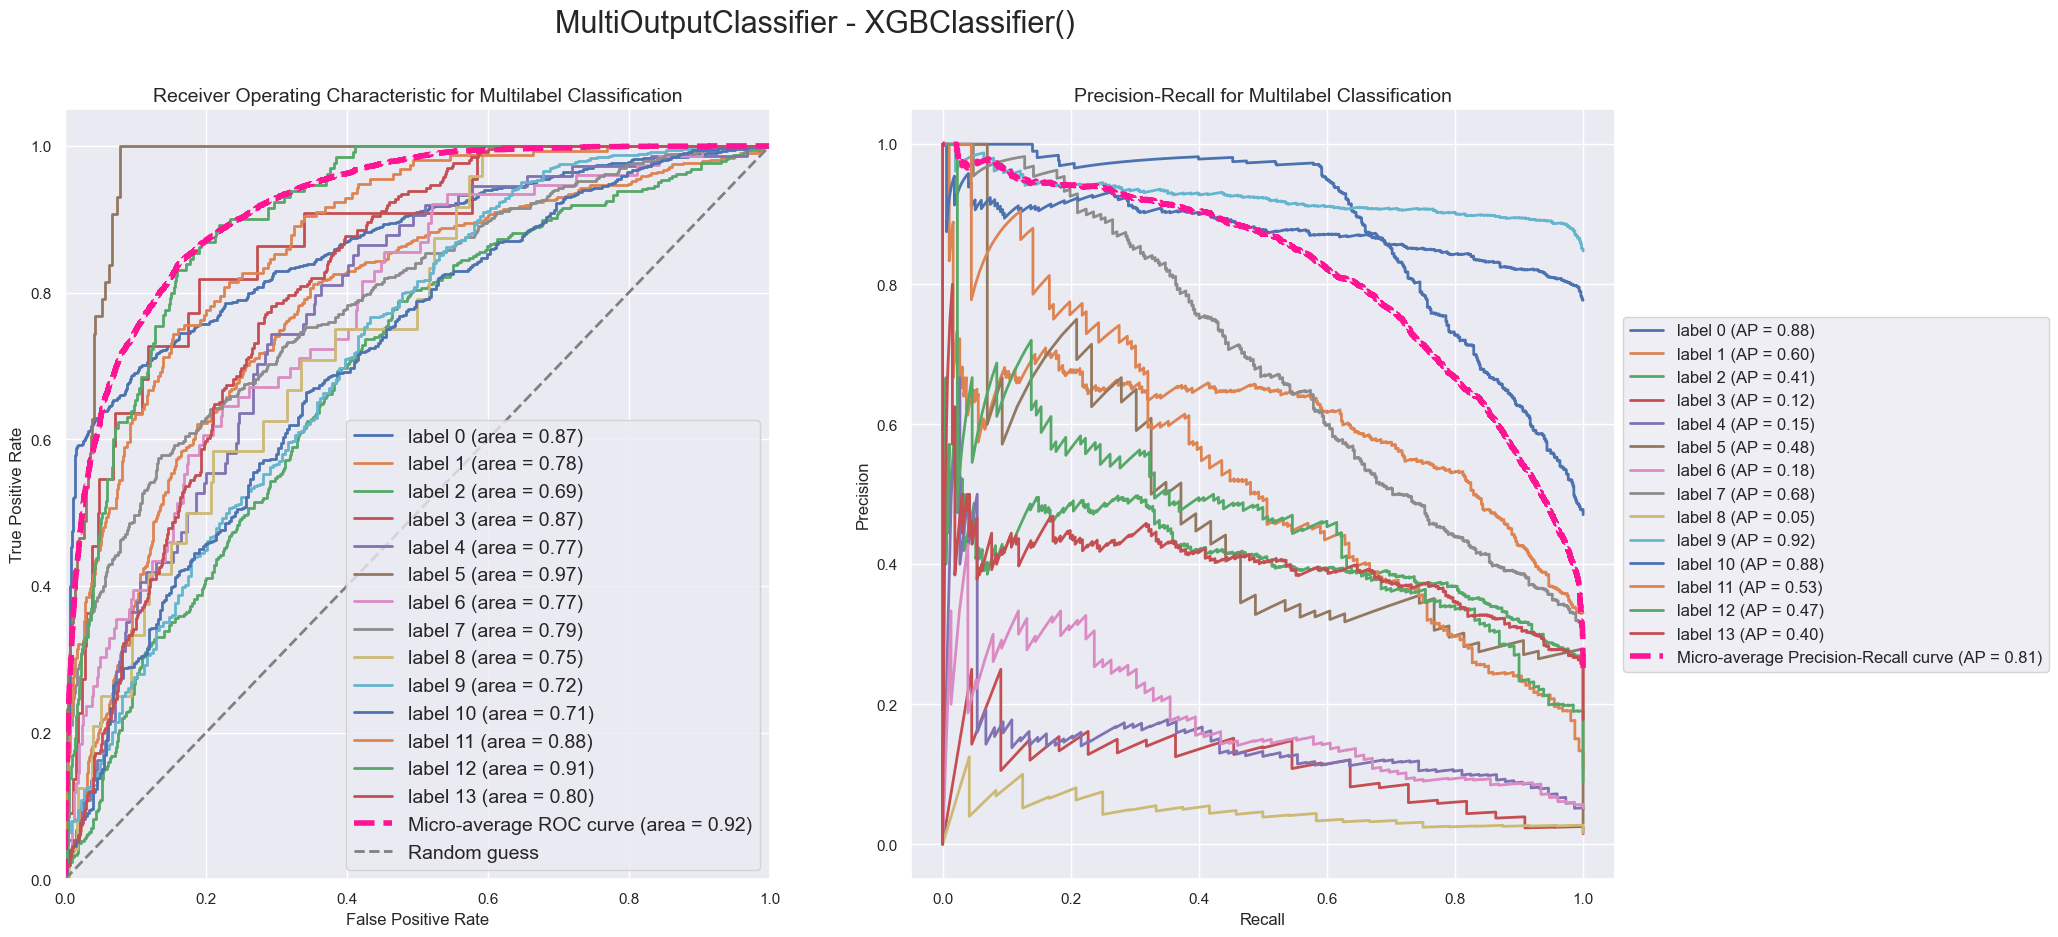

In [95]:
# Compute ROC curve and ROC area for each class
n_classes = y_train.shape[1]
# y_score = mxgb_clf.predict_proba(X_test)   # it is a list of arrays

# # https://stackoverflow.com/questions/67104496/how-to-correctly-reshape-the-multiclass-output-of-predict-proba-of-a-sklearn-cla
mxgb_y_score = np.hstack([i[:,1].reshape(-1,1) for i in mxgb_clf.predict_proba(X_test)])

plot_multilabel_auc_pr(n_classes, y_test, mxgb_y_score, 'MultiOutputClassifier - XGBClassifier()' )

### Label Powerset - RandomForestClassifier()

![Label Powerset](https://miro.medium.com/v2/resize:fit:720/format:webp/1*iQBP0rkxmqtXgba1EdNlRQ.png)

In [96]:
from skmultilearn.problem_transform import LabelPowerset

start = time.time()
lprf_classifier = LabelPowerset(
    classifier = RandomForestClassifier(),
    require_dense = [False, True]
)

lprf_classifier.fit(X_train, y_train)
lprf_y_hat=lprf_classifier.predict(X_test)

print("Time used: ",timedelta(seconds=time.time()-start))

Time used:  0:01:09.269994


In [97]:
getEvaluationMetrics (y_test, lprf_y_hat, clf_name="LabelPowerset - RandomForestClassifier()")

LabelPowerset - RandomForestClassifier()
                  EVALUATION
------------------------------------------------
F1-score (micro): 0.688
Hamming Loss: 0.137
Exact Match Ratio: 0.277
------------------------------------------------
Classification Report
------------------------------------------------
              precision    recall  f1-score   support

           0       0.92      0.57      0.71       691
           1       0.64      0.42      0.51       485
           2       0.42      0.14      0.22       387
           3       0.00      0.00      0.00        22
           4       0.00      0.00      0.00        74
           5       0.00      0.00      0.00        43
           6       0.00      0.00      0.00        76
           7       0.79      0.29      0.42       437
           8       0.00      0.00      0.00        24
           9       0.88      0.96      0.92      1244
          10       0.81      0.95      0.87      1141
          11       0.50      0.04      0.08

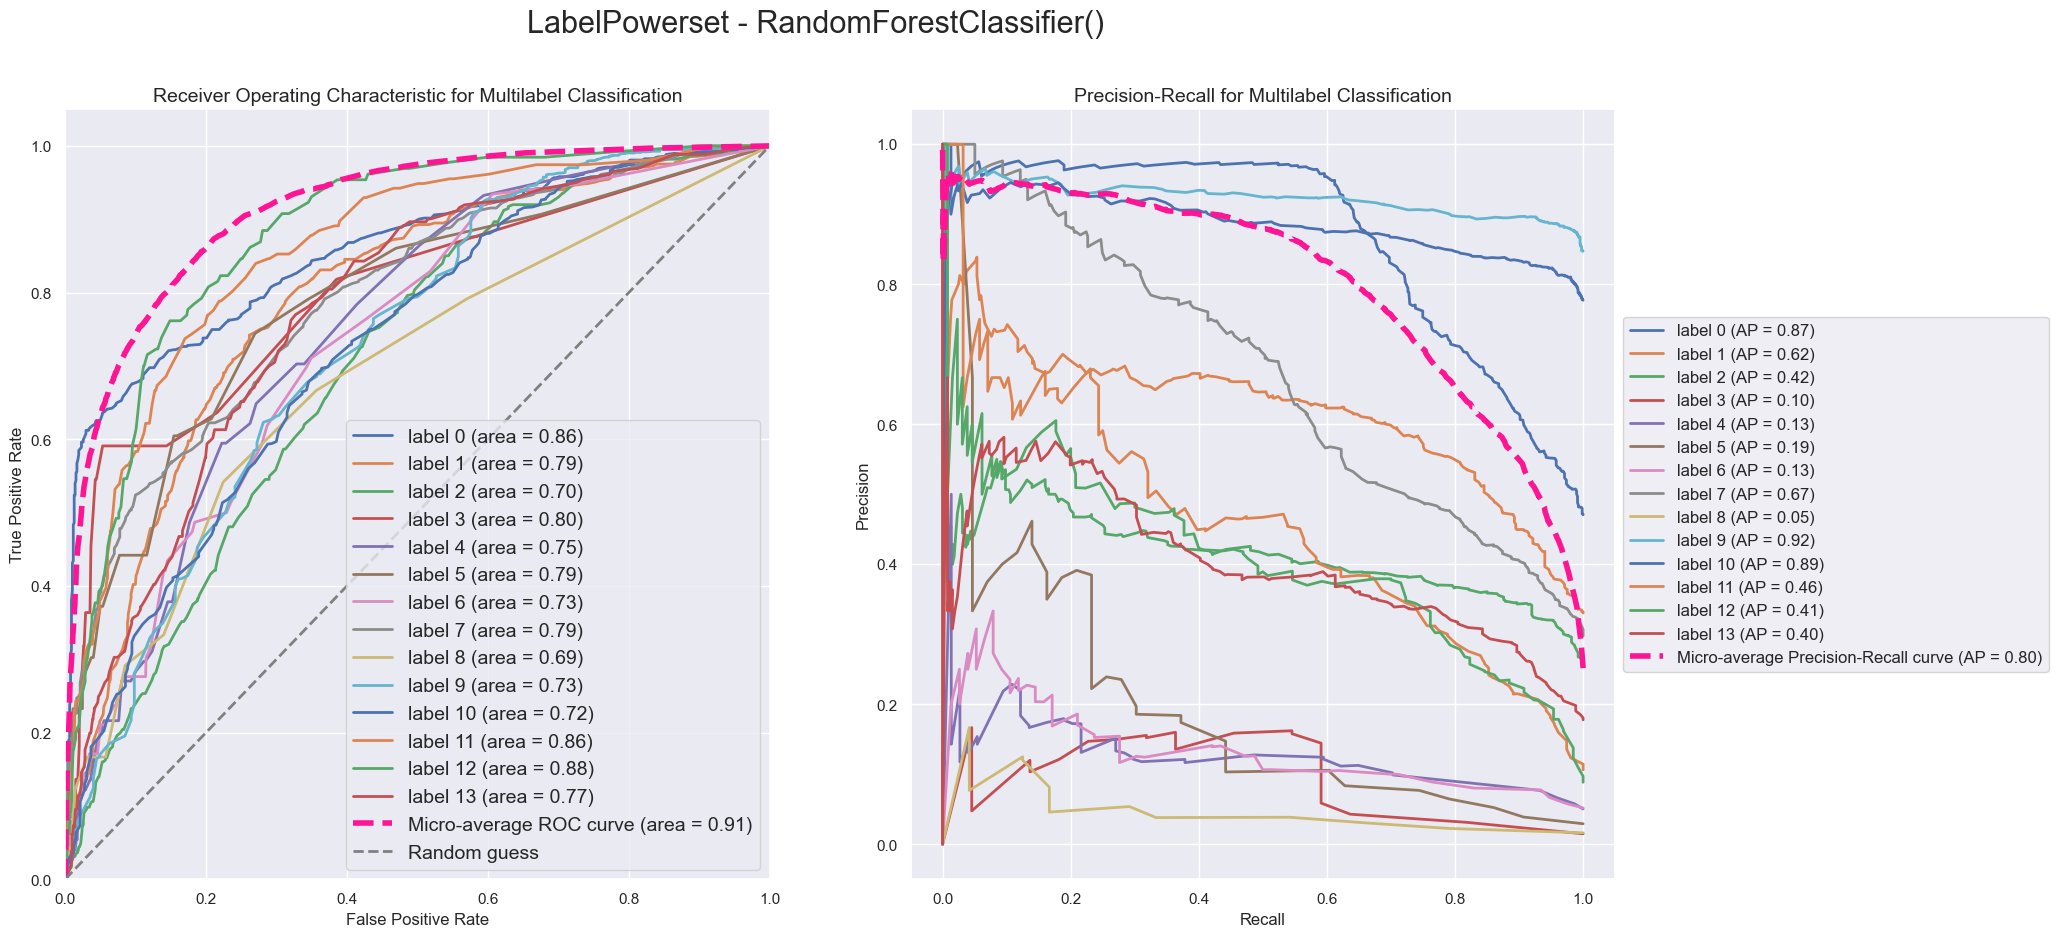

In [99]:
# Compute ROC curve and ROC area for each class
n_classes = y_train.shape[1]
lprf_y_score = lprf_classifier.predict_proba(X_test)   # it is scipy.sparse._lil.lil_matrix

# Convert y_score to dense numpy array if it's sparse
if hasattr(lprf_y_score, 'toarray'):
    lprf_y_score = lprf_y_score.toarray()

plot_multilabel_auc_pr(n_classes, y_test, lprf_y_score, 'LabelPowerset - RandomForestClassifier()' )

### Label Powerset - XGBClassifier()

In [100]:
start=time.time()

lpxg_classifier = LabelPowerset(
    classifier = XGBClassifier()
)

lpxg_classifier.fit(X_train, y_train)
lpxg_y_hat=lpxg_classifier.predict(X_test)
print("Time used: ",timedelta(seconds=time.time()-start))

Time used:  0:06:08.796677


In [101]:
getEvaluationMetrics (y_test, lpxg_y_hat, clf_name="Label Powerset - XGBClassifier()")

Label Powerset - XGBClassifier()
                  EVALUATION
------------------------------------------------
F1-score (micro): 0.65
Hamming Loss: 0.162
Exact Match Ratio: 0.185
------------------------------------------------
Classification Report
------------------------------------------------
              precision    recall  f1-score   support

           0       0.71      0.70      0.70       691
           1       0.50      0.39      0.44       485
           2       0.34      0.15      0.21       387
           3       0.00      0.00      0.00        22
           4       0.00      0.00      0.00        74
           5       0.00      0.00      0.00        43
           6       0.00      0.00      0.00        76
           7       0.51      0.37      0.43       437
           8       0.00      0.00      0.00        24
           9       0.85      0.93      0.89      1244
          10       0.80      0.84      0.82      1141
          11       0.40      0.08      0.13       15

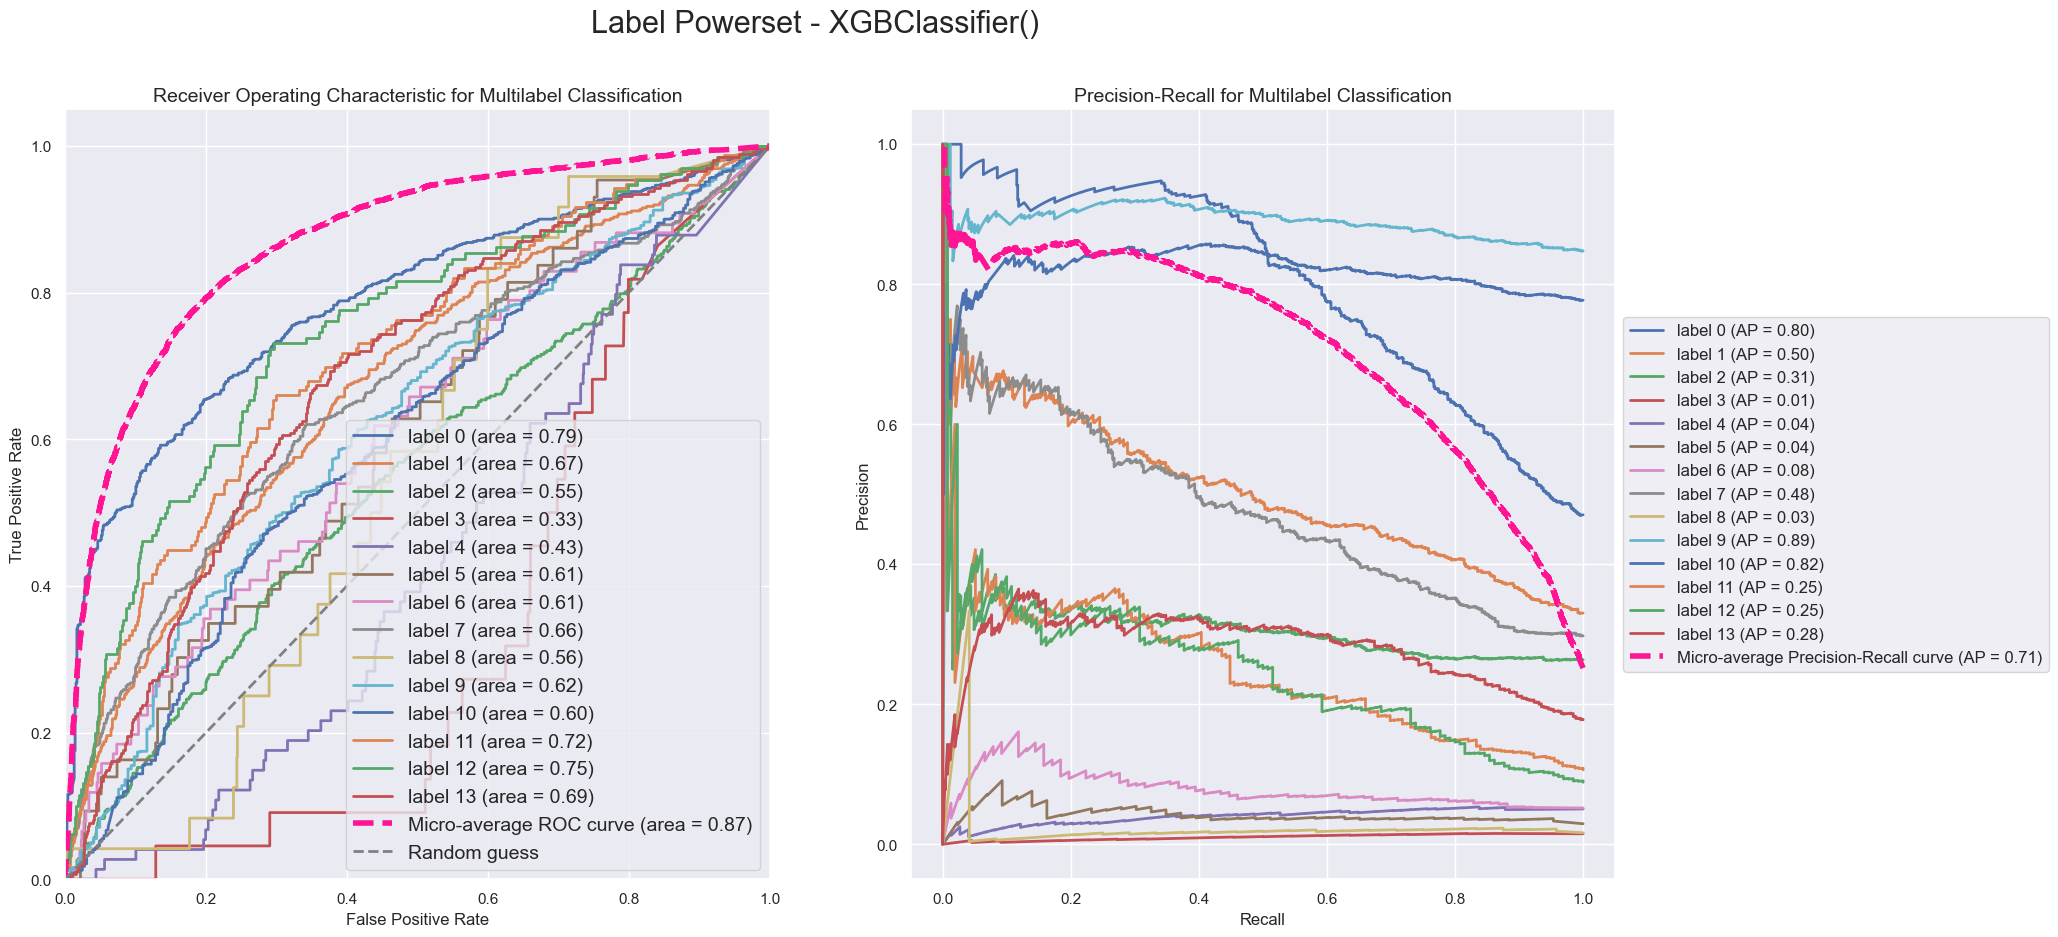

In [104]:
n_classes = y_train.shape[1]
lpxg_y_score = lpxg_classifier.predict_proba(X_test)   # it is scipy.sparse._lil.lil_matrix

# Convert y_score to dense numpy array if it's sparse
if hasattr(lpxg_y_score, 'toarray'):
    lpxg_y_score = lpxg_y_score.toarray()
    
plot_multilabel_auc_pr(n_classes, y_test, lpxg_y_score, 'Label Powerset - XGBClassifier()' )

### Classifier Chains

![Classifier Chains](https://miro.medium.com/v2/resize:fit:720/format:webp/1*awDUqTiolGsJzT7nBH0tNQ.png)

### ClassifierChain - LGBMClassifier()

In [105]:
# https://www.analyticsvidhya.com/blog/2017/08/introduction-to-multi-label-classification/

from skmultilearn.problem_transform import ClassifierChain
start=time.time()

cclg_classifier = ClassifierChain(
    classifier = LGBMClassifier() 
)

cclg_classifier.fit(X_train,y_train)
cclg_y_hat=cclg_classifier.predict(X_test)
print("Time used: ",timedelta(seconds=time.time()-start))

[LightGBM] [Info] Number of positive: 6218, number of negative: 6958
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002617 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2530
[LightGBM] [Info] Number of data points in the train set: 13176, number of used features: 179
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.471919 -> initscore=-0.112444
[LightGBM] [Info] Start training from score -0.112444
[LightGBM] [Info] Number of positive: 4367, number of negative: 8809
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002550 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2532
[LightGBM] [Info] Number of data points in the train set: 13176, number of used features: 180
[LightGBM] [Info] [b

In [106]:
getEvaluationMetrics (y_test, cclg_y_hat, clf_name="ClassifierChain - LGBMClassifier()")

ClassifierChain - LGBMClassifier()
                  EVALUATION
------------------------------------------------
F1-score (micro): 0.736
Hamming Loss: 0.127
Exact Match Ratio: 0.29
------------------------------------------------
Classification Report
------------------------------------------------
              precision    recall  f1-score   support

           0       0.87      0.68      0.77       691
           1       0.61      0.65      0.63       485
           2       0.45      0.32      0.37       387
           3       1.00      0.05      0.09        22
           4       0.00      0.00      0.00        74
           5       0.55      0.26      0.35        43
           6       0.53      0.12      0.19        76
           7       0.75      0.47      0.58       437
           8       0.00      0.00      0.00        24
           9       0.88      0.99      0.93      1244
          10       0.81      0.98      0.89      1141
          11       0.64      0.31      0.42       

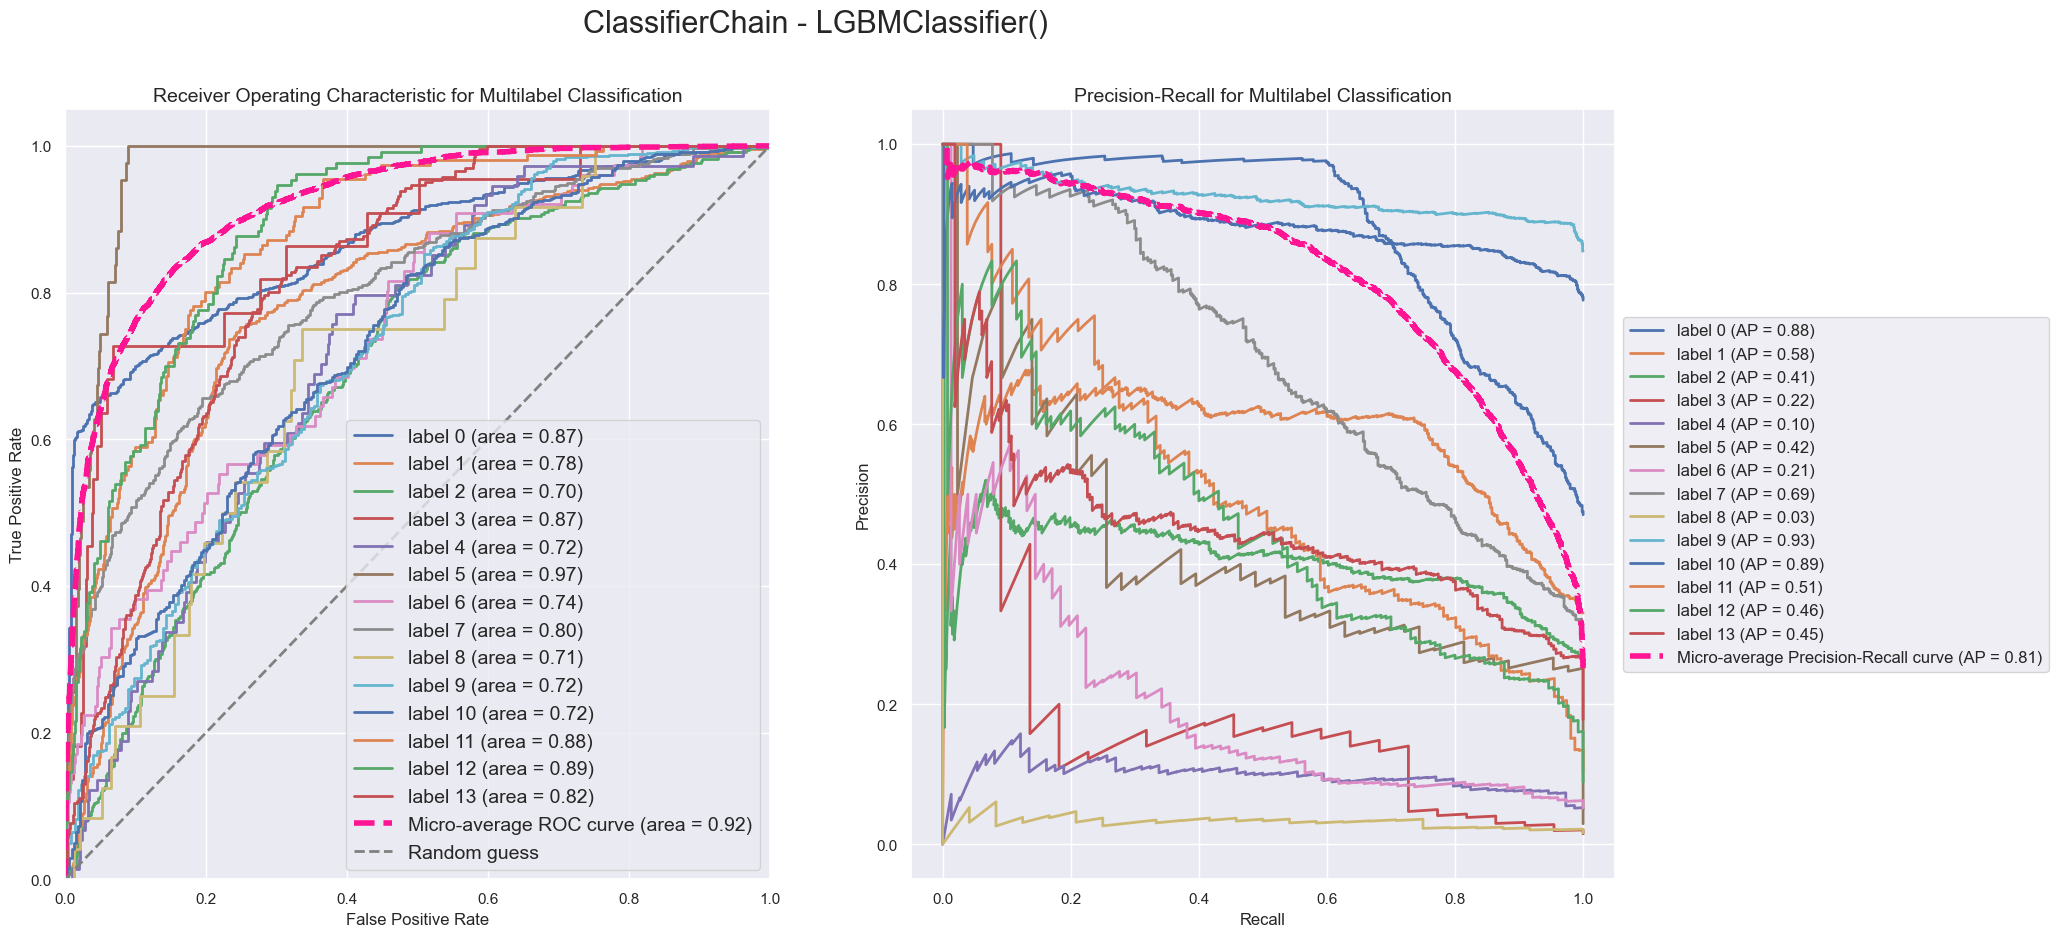

In [107]:
# Compute ROC curve and ROC area for each class
n_classes = y_train.shape[1]
cclg_y_score = cclg_classifier.predict_proba(X_test)   # it is scipy.sparse._lil.lil_matrix

# Convert y_score to dense numpy array if it's sparse
if hasattr(cclg_y_score, 'toarray'):
    cclg_y_score = cclg_y_score.toarray()

plot_multilabel_auc_pr(n_classes, y_test, cclg_y_score, 'ClassifierChain - LGBMClassifier()' )

### ClassifierChain - RandomForestClassifier()

In [108]:
from skmultilearn.problem_transform import ClassifierChain

start=time.time()
ccrf_classifier = ClassifierChain(
    classifier = RandomForestClassifier(),
    require_dense = [False, True],
    order=[i for i in range(y_train.shape[1])]
)

ccrf_classifier.fit(X_train,y_train)
ccrf_y_hat=ccrf_classifier.predict(X_test)
print("Time used: ",timedelta(seconds=time.time()-start))

Time used:  0:04:08.909613


In [109]:
getEvaluationMetrics (y_test, ccrf_y_hat, clf_name="ClassifierChain - RandomForestClassifier()")

ClassifierChain - RandomForestClassifier()
                  EVALUATION
------------------------------------------------
F1-score (micro): 0.727
Hamming Loss: 0.126
Exact Match Ratio: 0.283
------------------------------------------------
Classification Report
------------------------------------------------
              precision    recall  f1-score   support

           0       0.86      0.70      0.77       691
           1       0.63      0.60      0.62       485
           2       0.47      0.26      0.34       387
           3       0.00      0.00      0.00        22
           4       0.00      0.00      0.00        74
           5       1.00      0.07      0.13        43
           6       0.00      0.00      0.00        76
           7       0.78      0.38      0.51       437
           8       0.00      0.00      0.00        24
           9       0.88      0.98      0.93      1244
          10       0.81      0.98      0.89      1141
          11       0.77      0.15      0.

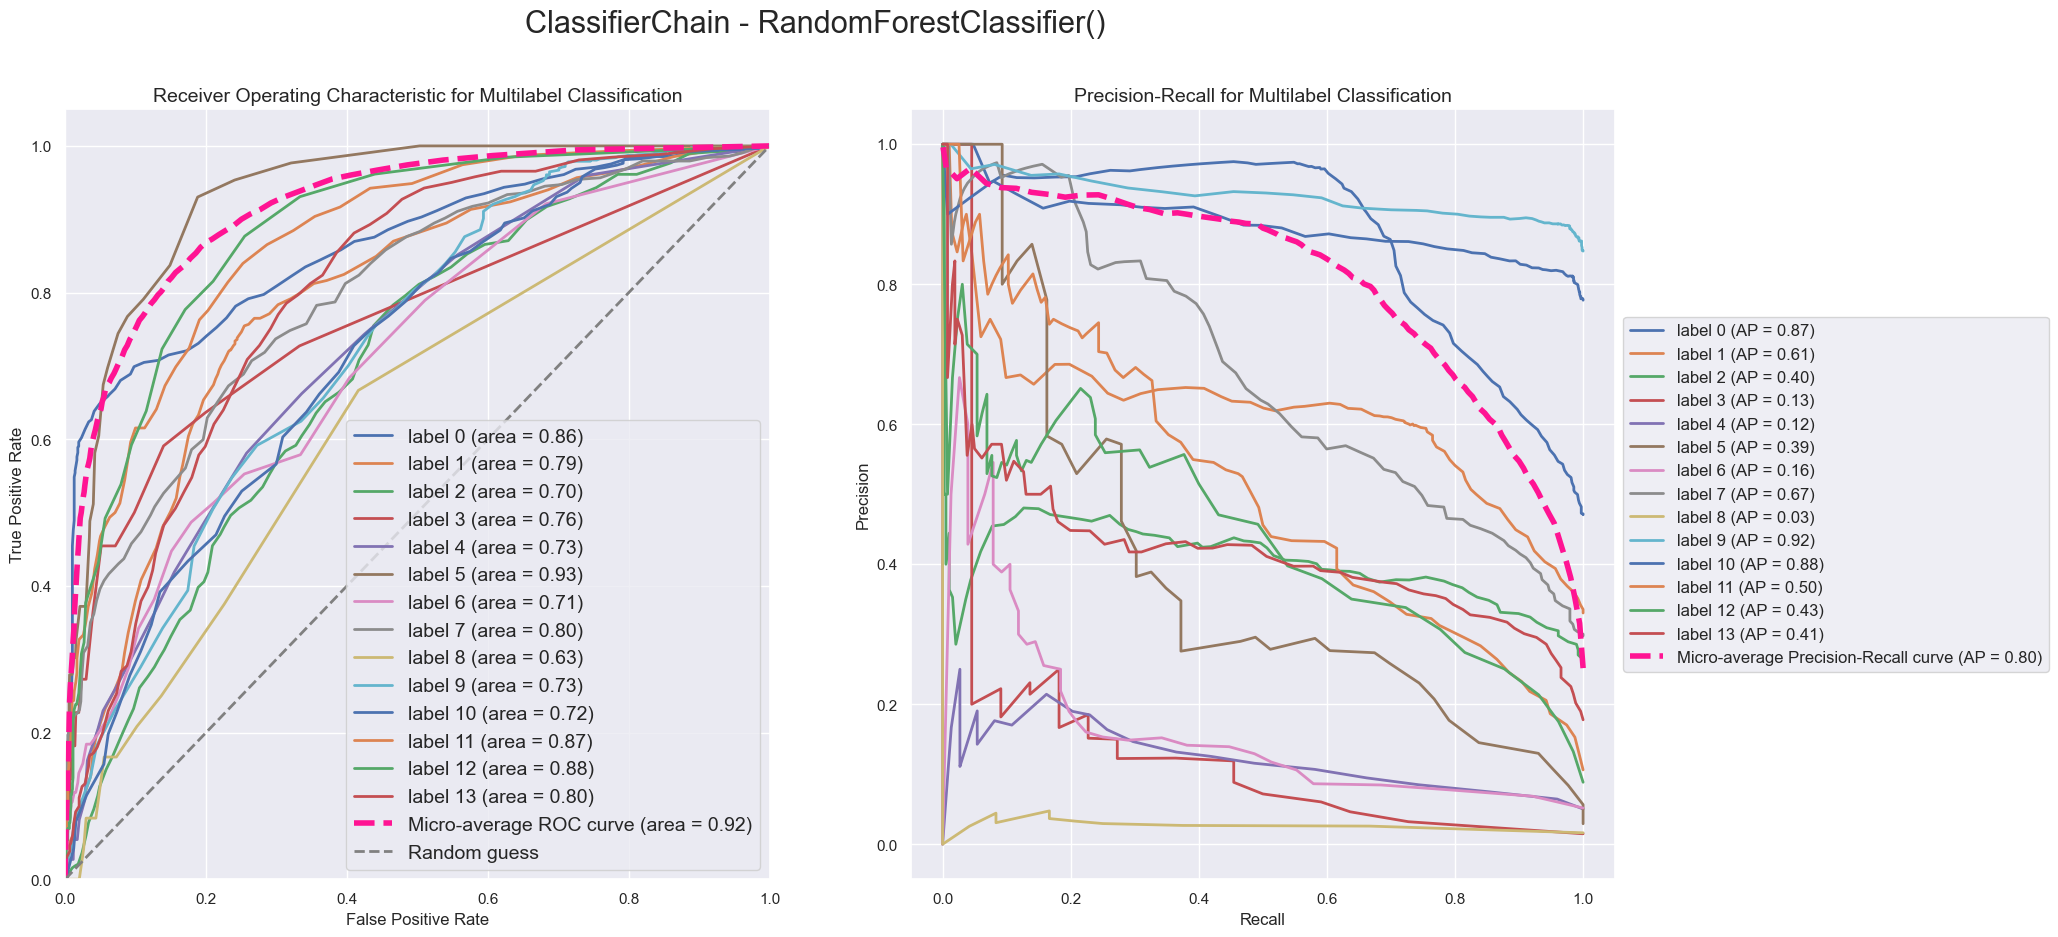

In [110]:
# Compute ROC curve and ROC area for each class
n_classes = y_train.shape[1]
ccrf_y_score = ccrf_classifier.predict_proba(X_test)   # it is scipy.sparse._lil.lil_matrix

# Convert y_score to dense numpy array if it's sparse
if hasattr(ccrf_y_score, 'toarray'):
    ccrf_y_score = ccrf_y_score.toarray()

plot_multilabel_auc_pr(n_classes, y_test, ccrf_y_score, 'ClassifierChain - RandomForestClassifier()' )

###  Adapted Algorithm -- Multi-label k-Nearest Neighbour (MLkNN) algorithm and Binary Relevance KNN classifier is not working on latest version of sklearn
#### https://stackoverflow.com/questions/69734051/mlknn-int-takes-1-positional-argument-but-2-were-given-with-fit-method#comment124249802_69734051

    !pip uninstall scikit-learn -y
    !pip install scikit-learn==0.24.1

    OR
#### https://stackoverflow.com/questions/74613688/typeerror-skmultilearn-error-with-multilabel-knn    
    It's a bug, you need to open the "mlknn.py" file and replace self.knn = NearestNeighbors(self.k) with self.knn =NearestNeighbors(n_neighbors=self.k)

    "mlknn.py" or "brknn.py" file location shows in error message (In my case: C:\Users\xxx\AppData\Roaming\Python\Python310\site-packages\skmultilearn\adapt)

In [111]:
# http://scikit.ml/api/skmultilearn.adapt.mlknn.html
from skmultilearn.adapt import MLkNN
from sklearn.model_selection import GridSearchCV

start=time.time()

parameters = {'k': range(10, 20), 's':np.linspace(0.1, 0.5, num=5)} # s is the smoothing parameter
score = 'f1_macro'

clf = GridSearchCV(MLkNN(), parameters, scoring=score)
clf.fit(X_train, y_train)

print ('best parameters :', clf.best_params_, 
       'best score: ', clf.best_score_)

print("Grid Search Time used: ",timedelta(seconds=time.time()-start))

best parameters : {'k': 10, 's': 0.1} best score:  nan
Grid Search Time used:  0:24:15.535158


In [112]:
start=time.time()

mknn_classifier = MLkNN(k=10, s=0.1)

# train
mknn_classifier.fit(X_train, y_train)
# predict
mknn_y_hat=mknn_classifier.predict(X_test)
print("Time used: ",timedelta(seconds=time.time()-start))

Time used:  0:00:08.101779


In [113]:
getEvaluationMetrics (y_test, mknn_y_hat, clf_name="Adapted Algorithm -- Multi-label k-Nearest Neighbour (MLkNN) algorithm")

Adapted Algorithm -- Multi-label k-Nearest Neighbour (MLkNN) algorithm
                  EVALUATION
------------------------------------------------
F1-score (micro): 0.642
Hamming Loss: 0.161
Exact Match Ratio: 0.184
------------------------------------------------
Classification Report
------------------------------------------------
              precision    recall  f1-score   support

           0       0.63      0.53      0.58       691
           1       0.42      0.18      0.25       485
           2       0.35      0.16      0.22       387
           3       0.00      0.00      0.00        22
           4       0.00      0.00      0.00        74
           5       0.00      0.00      0.00        43
           6       0.00      0.00      0.00        76
           7       0.49      0.30      0.37       437
           8       0.00      0.00      0.00        24
           9       0.86      0.98      0.92      1244
          10       0.80      0.93      0.86      1141
          11 

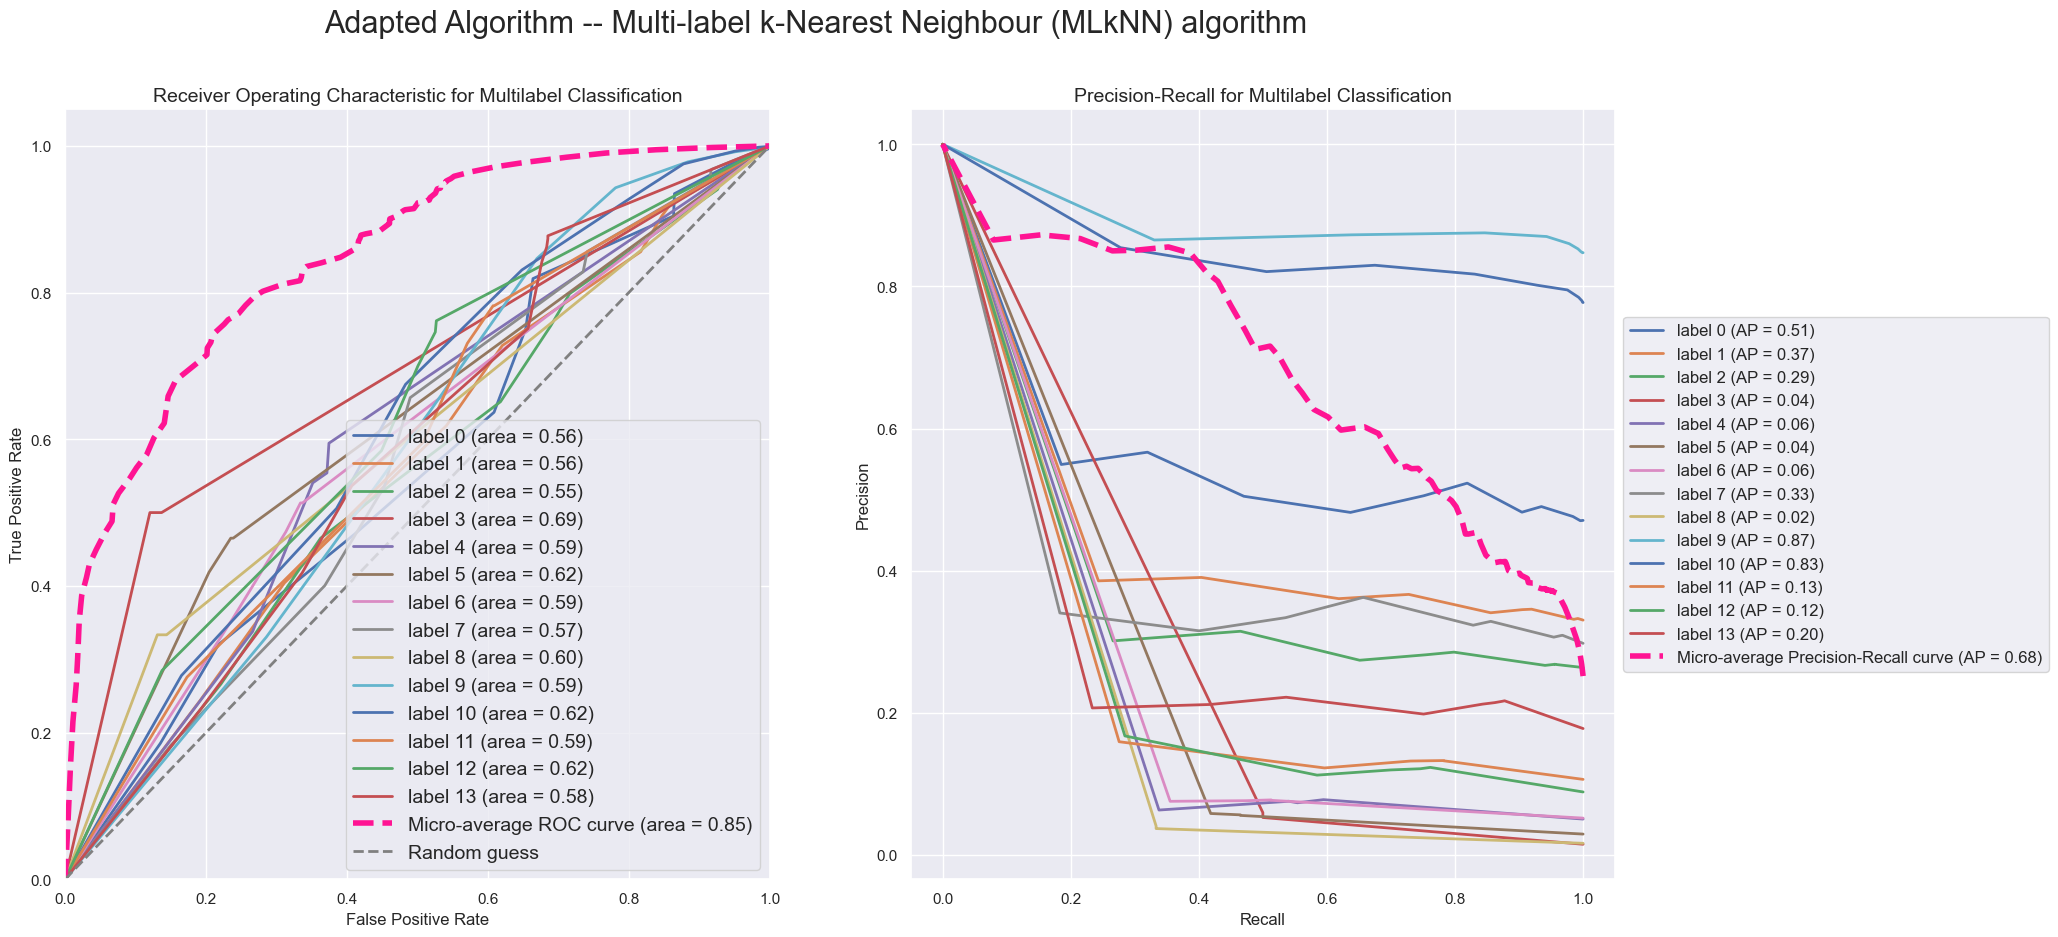

In [114]:
n_classes = y_train.shape[1]
mknn_y_score = mknn_classifier.predict_proba(X_test)   # it is scipy.sparse._lil.lil_matrix

# Convert y_score to dense numpy array if it's sparse
if hasattr(mknn_y_score, 'toarray'):
    mknn_y_score = mknn_y_score.toarray()

plot_multilabel_auc_pr(n_classes, y_test, mknn_y_score, 'Adapted Algorithm -- Multi-label k-Nearest Neighbour (MLkNN) algorithm' )

### BRkNNaClassifier - Binary Relevance k-Nearest Neighbours

In [115]:
from skmultilearn.adapt import BRkNNaClassifier

start=time.time()
parameters = {'k': range(3,10)}
score = 'f1_micro'

classifier = GridSearchCV(BRkNNaClassifier(), parameters, scoring=score)
classifier.fit(X_train, y_train)

print('training time taken: ',timedelta(seconds=time.time()-start))
print('best parameters :', classifier.best_params_,
      'best score: ',classifier.best_score_)

training time taken:  0:00:00.431544
best parameters : {'k': 3} best score:  nan


In [121]:
start=time.time()

BRkNNa_classifier = BRkNNaClassifier(k=3)

# train
BRkNNa_classifier.fit(X_train, y_train)
# predict
BRkNNa_y_hat=BRkNNa_classifier.predict(X_test)
print('training time taken: ',timedelta(seconds=time.time()-start))

training time taken:  0:00:00.518175


In [117]:
getEvaluationMetrics (y_test, BRkNNa_y_hat, clf_name="Adapted Algorithm -- BRkNNaClassifier()")

Adapted Algorithm -- BRkNNaClassifier()
                  EVALUATION
------------------------------------------------
F1-score (micro): 0.628
Hamming Loss: 0.178
Exact Match Ratio: 0.136
------------------------------------------------
Classification Report
------------------------------------------------
              precision    recall  f1-score   support

           0       0.59      0.62      0.60       691
           1       0.39      0.35      0.37       485
           2       0.36      0.23      0.28       387
           3       0.00      0.00      0.00        22
           4       0.05      0.01      0.02        74
           5       0.00      0.00      0.00        43
           6       0.06      0.01      0.02        76
           7       0.46      0.35      0.40       437
           8       0.00      0.00      0.00        24
           9       0.86      0.95      0.90      1244
          10       0.81      0.88      0.84      1141
          11       0.13      0.06      0.08 

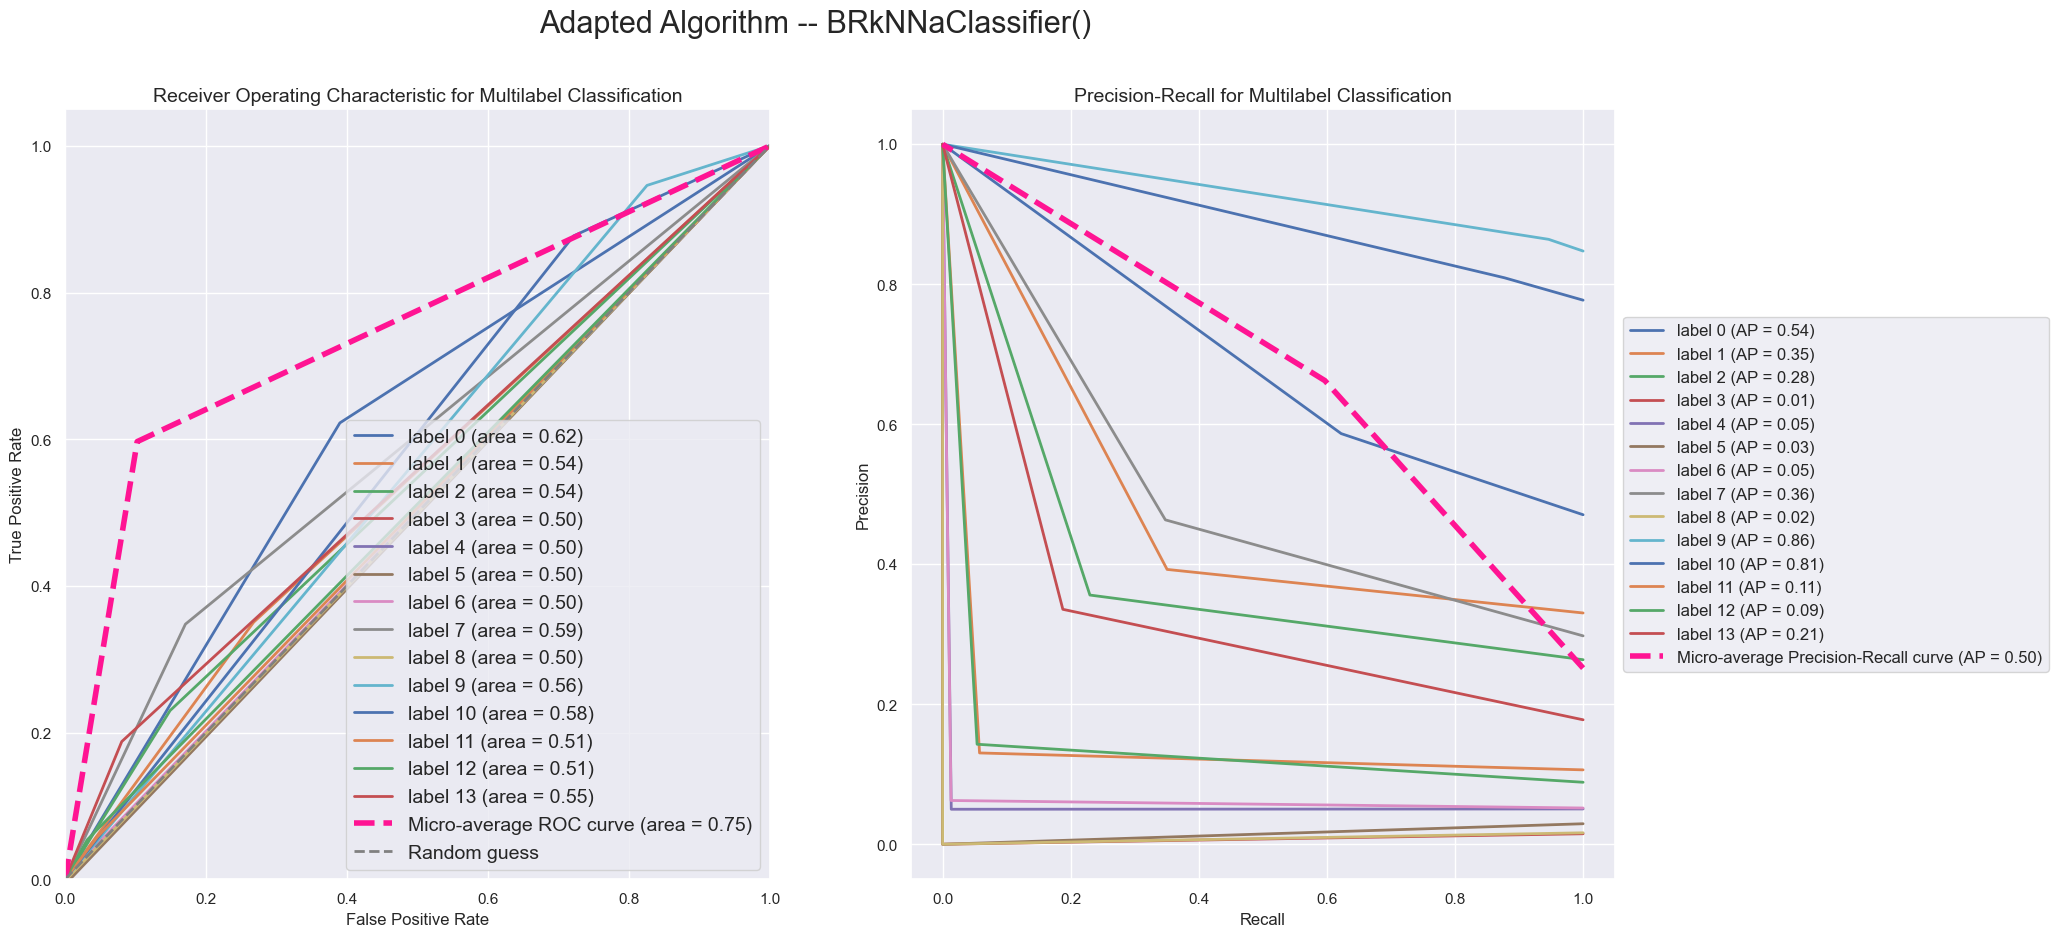

In [125]:
n_classes = y_train.shape[1]
#BRkNNa_y_score = BRkNNa_classifier.predict_proba(X_test)   # AttributeError: 'BRkNNaClassifier' object has no attribute 'predict_proba'

# Obtain decision function scores using the predict method  
# converted the output to an array using toarray() because BRkNNaClassifier outputs sparse matrices
BRkNNa_y_score = BRkNNa_classifier.predict(X_test).toarray()

plot_multilabel_auc_pr(n_classes, y_test, BRkNNa_y_score, 'Adapted Algorithm -- BRkNNaClassifier()' )

## The models get the best scores from above are using BinaryRelevance - LGBMClassifier() and ClassifierChain - LGBMClassifier(). Hyperparameter tuning may need for model optimation

## The worst model is using Adapted Algorithms.

### Reference


    https://wimukthimadhusanka85.medium.com/multi-label-classification-e259896182da
    https://pub.towardsai.net/overview-of-multilabel-classifications-3680fe3833d6
    https://xang1234.github.io/multi-label/
    https://medium.com/data-science-in-your-pocket/multi-label-classification-for-beginners-with-codes-6b098cc76f99
    https://www.causeweb.org/usproc/sites/default/files/usclap/2019-1/Comparison%20of%20Four%20Multi-Label%20Classification%20Methods.pdf
    https://bobrupakroy.medium.com/chained-and-multilabel-algorithms-6b378ec761d3
    https://towardsdatascience.com/evaluating-multi-label-classifiers-a31be83da6ea
    https://www.kdnuggets.com/2023/08/multilabel-classification-introduction-python-scikitlearn.html
    https://iamvishnu-varapally.medium.com/evaluating-metrics-for-multi-label-classification-and-implementations-ebabead60afd
    https://medium.com/analytics-vidhya/metrics-for-multi-label-classification-49cc5aeba1c3
    https://medium.com/gumgum-tech/creating-balanced-multi-label-datasets-for-model-training-and-evaluation-16b6a3a2d912
    https://medium.com/gumgum-tech/creating-a-balanced-multi-label-dataset-for-machine-learning-9945abad2616    
    http://scikit.ml/userguide.html
        
    https://gabrielziegler3.medium.com/multiclass-multilabel-classification-with-xgboost-66195e4d9f2d
    https://www.kaggle.com/code/para24/ovr-vs-multioutput-vs-classifier-chaining
    https://bobrupakroy.medium.com/chained-and-multilabel-algorithms-6b378ec761d3
    https://stackoverflow.com/questions/42819460/what-is-the-difference-between-onevsrestclassifier-and-multioutputclassifier-in

    https://www.kaggle.com/code/ravikrishnareddy/multi-label-classification
    https://www.kaggle.com/code/srikanth09556/multi-label-classification-women-health-care
    https://medium.com/@ilyurek/multi-label-classification-with-python-a-simple-guide-c0fe04471ad7
    https://andy-wang.medium.com/bags-of-tricks-for-multi-label-classification-dc54b87f79ec
    
    https://towardsdatascience.com/journey-to-the-center-of-multi-label-classification-384c40229bff
    https://www.kaggle.com/code/dongr0510/multi-label-classification-simple-example
    https://gabrielziegler3.medium.com/multiclass-multilabel-classification-with-xgboost-66195e4d9f2d
    https://medium.com/p/b1bcb7c7364c


    https://medium.com/institute-for-applied-computational-science/multi-label-classification-of-thoracic-diseases-162573d7642b
    https://medium.com/@matrixB/modified-cross-entropy-loss-for-multi-label-classification-with-class-a8afede21eb9


#### Metric Reference
    https://heartbeat.comet.ml/evaluation-metrics-for-classification-models-in-machine-learning-part-1-24e1ed84670
    https://heartbeat.comet.ml/evaluation-metrics-for-classification-models-in-machine-learning-part-2-f110128fa4f9
    https://medium.com/analytics-vidhya/performance-metrics-classification-model-69a5546b118c
    https://medium.com/analytics-vidhya/quick-model-validation-metrics-classification-e6e63fbf9aec
    https://medium.com/@megha.natarajan/intuition-behind-auc-and-precision-recall-curves-7a33d2d45e02
    https://panjeh.medium.com/confusion-matrix-multilabel-indicator-is-not-supported-in-scikit-learn-624b6ab60508
    https://medium.com/synthesio-engineering/precision-accuracy-and-f1-score-for-multi-label-classification-34ac6bdfb404